<a href="https://colab.research.google.com/github/Bilpapster/NNs-playground/blob/main/3_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Third assignment in Neural Networks - Deep Learning

### Assignment Theme: Autoencoding

> Vasileios Papastergios (ID: 3651)


---


# Introduction

The current Jupiter Notebook contains python source code for the third obligatory assignment in the course of [Neural Networks - Deep Learing](https://qa.auth.gr/en/x/class/1/600237255). The author attended the course during their 7th semester of studies at the [Aristotle University of Thessaloniki (AUTH)](https://www.csd.auth.gr/en/).

The current assignment focuses on implementing various flavors of autoencoder Neural Networks. The dataset used for the current assignment is [MNIST](https://en.wikipedia.org/wiki/MNIST_database#:~:text=Article%20Talk,the%20field%20of%20machine%20learning).

The current notebook also serves as assignment report and documentation, since it also includes comments and/or reasoning of the author along with the investigated code segment of interest.

# 0. Data loading

At first we load the data and print the shape of the train and test set. As we can see, there are 60'000 images for training and 10'000 images for testing. Each one of them has dimensions 28 x 28 pixels and is single-channeled.

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

import numpy as np

import keras
from keras.datasets import mnist
data = mnist.load_data()
(X_train, y_train), (X_test, y_test) = data

print(f"Shape of X_train: {np.shape(X_train)}")
print(f"Shape of y_train: {np.shape(y_train)}")
print(f"Shape of X_test : {np.shape(X_test)}")
print(f"Shape of y_test : {np.shape(y_test)}")

Mounted at /gdrive
11490434/11490434 [==============================] - 0s 0us/step
Shape of X_train: (60000, 28, 28)
Shape of y_train: (60000,)
Shape of X_test : (10000, 28, 28)
Shape of y_test : (10000,)


We also create a "flattened" (2-Dimensional) version of the train and tests images. We are going to use the flattened images later on in this assignment, when applying PCA to the images.

In [ ]:
X_train_flattened = np.reshape(a=X_train, newshape=(-1, 28*28))
X_test_flattened  = np.reshape(a=X_test , newshape=(-1, 28*28))

print(f"Shape of X_train_flattened: {np.shape(X_train_flattened)}")
print(f"Shape of X_test_flattened : {np.shape(X_test_flattened)}")

Shape of X_train_flattened: (60000, 784)
Shape of X_test_flattened : (10000, 784)


We, also, perform some basic data exploration analysis. We take a random sample of a few images and plot them, in combination with their groundtruth label.

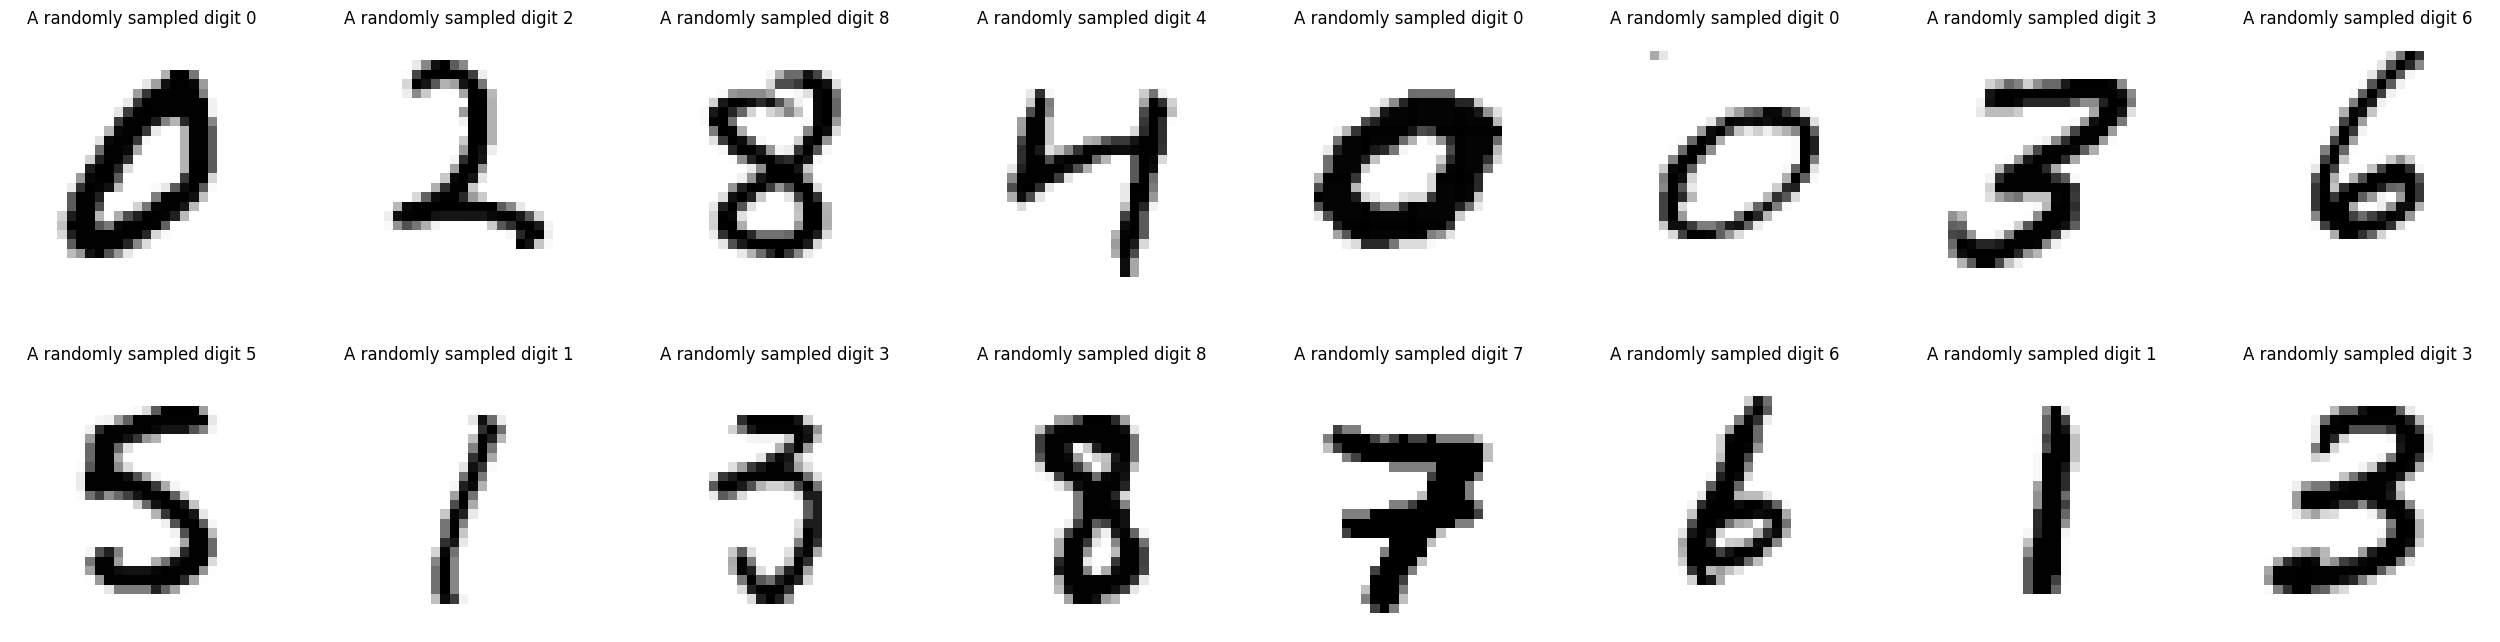

In [ ]:
# Data exploration

import matplotlib.pyplot as plt
from numpy.random import randint

def plot_MNIST_sample(rows=2, columns=5):
  random_indices = randint(0, len(X_train)-1, size=(rows, columns))

  fig, ax = plt.subplots(rows, columns, figsize=(columns*4, rows*4))

  for row in range(rows):
    for column in range(columns):
      ax[row][column].imshow(X_train[random_indices[row][column]], cmap='gray_r')
      ax[row][column].set_title(f"A randomly sampled digit {y_train[random_indices[row][column]]}")
      ax[row][column].axis("off")

plot_MNIST_sample(rows=2, columns=8)

Another important preprocessing step is to normalize the train and test matrices. Since they are both image matrices, we can normalize to $[0, 1]$ by dividing all values by $255$.

In [ ]:
def normalize_image_matrix(X_train, X_test):
  """
  a utility function that normalizes X_train and X_test
  matrices for MNIST dataset in [0, 1]
  """
  X_train = X_train.astype("float32")
  X_train /= 255.
  X_test = X_test.astype("float32")
  X_test /= 255.
  return X_train, X_test

X_train, X_test = normalize_image_matrix(X_train, X_test)

# 1. An autoencoder for MNIST reconstruction

We define two autoencoder variations that we are going to use later on in this assignment.

1. A convolutional, symmetric autoencoder with 3 CNN layers in each one of the encoder and decoder parts.

1. The same autoencoder, but with an MNIST classifier plugged in at the end. The classifier is "locked", i.e. its weights are not trainable.

In [ ]:
import keras
from keras import layers

# inspired by autoencoder architecture from keras official website:
# https://blog.keras.io/building-autoencoders-in-keras.html

def get_autoencoder_for_MNIST(name="MNIST_Autoencoder"):

  # ------------------------- INPUT -------------------------
  input = keras.Input(shape=(28, 28, 1))

  # ------------------------- ENCODER -------------------------
  x = layers.Conv2D(16, (5, 5), activation='relu', padding='same', strides=(2, 2))(input)
  x = layers.Conv2D(8, (5, 5), activation='relu', padding='same')(x)
  x = layers.Conv2D(8, (5, 5), activation='relu', padding='same', strides=(2, 2))(x)
  encoded = layers.Conv2D(8, (5, 5), activation='relu', padding='same', strides=(2, 2))(x)

  # at this point the representation is (4, 4, 8) i.e. 128-dimensional hidden representation

  # ------------------------- DECODER -------------------------
  x = layers.Conv2D(8, (5, 5), activation='relu', padding='same')(encoded)
  x = layers.UpSampling2D((2, 2))(x)
  x = layers.Conv2D(8, (5, 5), activation='relu', padding='same')(x)
  x = layers.UpSampling2D((2, 2))(x)
  x = layers.Conv2D(16, (3, 3), activation='relu')(x)
  x = layers.UpSampling2D((2, 2))(x)
  decoded = layers.Conv2D(1, (5, 5), activation='sigmoid', padding='same')(x)

  autoencoder = keras.Model(input, decoded, name=name)
  autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return autoencoder


def get_autoencoder_for_MNIST_with_classifier(name="MNIST_Autoencoder"):

  MNIST_classifier = keras.models.load_model('/gdrive/My Drive/Kaggle/MNIST_classifier.keras')

  # ------------------------- INPUT -------------------------
  input = keras.Input(shape=(28, 28, 1))

  # ------------------------- ENCODER -------------------------
  x = layers.Conv2D(16, (5, 5), activation='relu', padding='same', strides=(2, 2))(input)
  x = layers.Conv2D(8, (5, 5), activation='relu', padding='same', strides=(2, 2))(x)
  encoded = layers.Conv2D(8, (5, 5), activation='relu', padding='same', strides=(2, 2))(x)

  # at this point the representation is (4, 4, 8) i.e. 128-dimensional hidden representation

  # ------------------------- DECODER -------------------------
  x = layers.Conv2D(8, (5, 5), activation='relu', padding='same')(encoded)
  x = layers.UpSampling2D((2, 2))(x)
  x = layers.Conv2D(8, (5, 5), activation='relu', padding='same')(x)
  x = layers.UpSampling2D((2, 2))(x)
  x = layers.Conv2D(16, (3, 3), activation='relu')(x)
  x = layers.UpSampling2D((2, 2))(x)
  decoded = layers.Conv2D(1, (5, 5), activation='sigmoid', padding='same')(x)

  # ------------------------- CLASSIFIER -------------------------
  x = layers.Conv2D(16, (3, 3), activation='relu', padding='same', weights=MNIST_classifier.layers[0].get_weights(), trainable=False)(decoded)
  x = layers.MaxPooling2D((2, 2),                  padding='same', weights=MNIST_classifier.layers[1].get_weights(), trainable=False)(x)
  x = layers.Conv2D(8, (3, 3), activation='relu',  padding='same', weights=MNIST_classifier.layers[2].get_weights(), trainable=False)(x)
  x = layers.MaxPooling2D((2, 2),                  padding='same', weights=MNIST_classifier.layers[3].get_weights(), trainable=False)(x)
  x = layers.Conv2D(8, (3, 3), activation='relu',  padding='same', weights=MNIST_classifier.layers[4].get_weights(), trainable=False)(x)
  x = layers.MaxPooling2D((2, 2),                  padding='same', weights=MNIST_classifier.layers[5].get_weights(), trainable=False)(x)
  x = layers.Flatten()(x)
  x = layers.Dense(units=64, activation='relu',    name="Dense1", weights=MNIST_classifier.layers[7].get_weights(),  trainable=False)(x)
  x = layers.Dense(units=32, activation='relu',    name="Dense2", weights=MNIST_classifier.layers[8].get_weights(),  trainable=False)(x)
  output = layers.Dense(units=10, activation='softmax', name="output", weights=MNIST_classifier.layers[9].get_weights(), trainable=False)(x)

  autoencoder = keras.Model(input, output, name=name)
  autoencoder.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return autoencoder

We, then, train the simple autoencoder to reconstruct the input digit. We train for 100 epochs with a batch size of 128 training examples. The final test accuracy after 100 epochs is 81.44 % for the reconstructed images.

In [ ]:
# Defining the autoencoder
autoencoder_classic = get_autoencoder_for_MNIST(name="Classic_MNIST_autoencoder")

# Training the autoencoder
autoencoder_classic.fit(
                          X_train, X_train,
                          epochs=100,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(X_test, X_test),
                          verbose="auto"
                        )

# Save the autoencoder to disk for future use
autoencoder_classic.save('/gdrive/My Drive/Kaggle/MNIST_autoencoder_classic_3.keras')

# Using the autoencoder for reconstruction
reconstructed_images = autoencoder_classic.predict(X_test)

Epoch 1/100
469/469 [==============================] - 7s 8ms/step - loss: 0.1884 - accuracy: 0.8014 - val_loss: 0.1229 - val_accuracy: 0.8072
Epoch 2/100
469/469 [==============================] - 4s 8ms/step - loss: 0.1148 - accuracy: 0.8096 - val_loss: 0.1061 - val_accuracy: 0.8099
Epoch 3/100
469/469 [==============================] - 4s 9ms/step - loss: 0.1036 - accuracy: 0.8116 - val_loss: 0.0988 - val_accuracy: 0.8110
Epoch 4/100
469/469 [==============================] - 3s 7ms/step - loss: 0.0971 - accuracy: 0.8126 - val_loss: 0.0932 - val_accuracy: 0.8123
Epoch 5/100
469/469 [==============================] - 3s 7ms/step - loss: 0.0928 - accuracy: 0.8132 - val_loss: 0.0913 - val_accuracy: 0.8130
Epoch 6/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0900 - accuracy: 0.8136 - val_loss: 0.0871 - val_accuracy: 0.8129
Epoch 7/100
469/469 [==============================] - 4s 10ms/step - loss: 0.0878 - accuracy: 0.8139 - val_loss: 0.0853 - val_accuracy: 0.813

A simple utility function to print a sample of the original and the respective reconstructed image.

In [ ]:
import matplotlib.pyplot as plt
from numpy.random import randint


def plot_original_vs_reconstructed(original, reconstructed, columns=5):
  rows=2
  # random_indices = randint(0, len(original)-1, size=columns)
  random_indices = np.arange(stop=columns, dtype="int")

  fig, ax = plt.subplots(rows, columns, figsize=(columns*4, rows*4))

  for index, random_index in enumerate(random_indices):
    ax[0][index].imshow(original[random_index], cmap='gray')
    ax[0][index].set_title("Original")
    ax[0][index].axis("off")
    ax[1][index].imshow(reconstructed[random_index], cmap='gray')
    ax[1][index].set_title("Reconstructed")
    ax[1][index].axis("off")

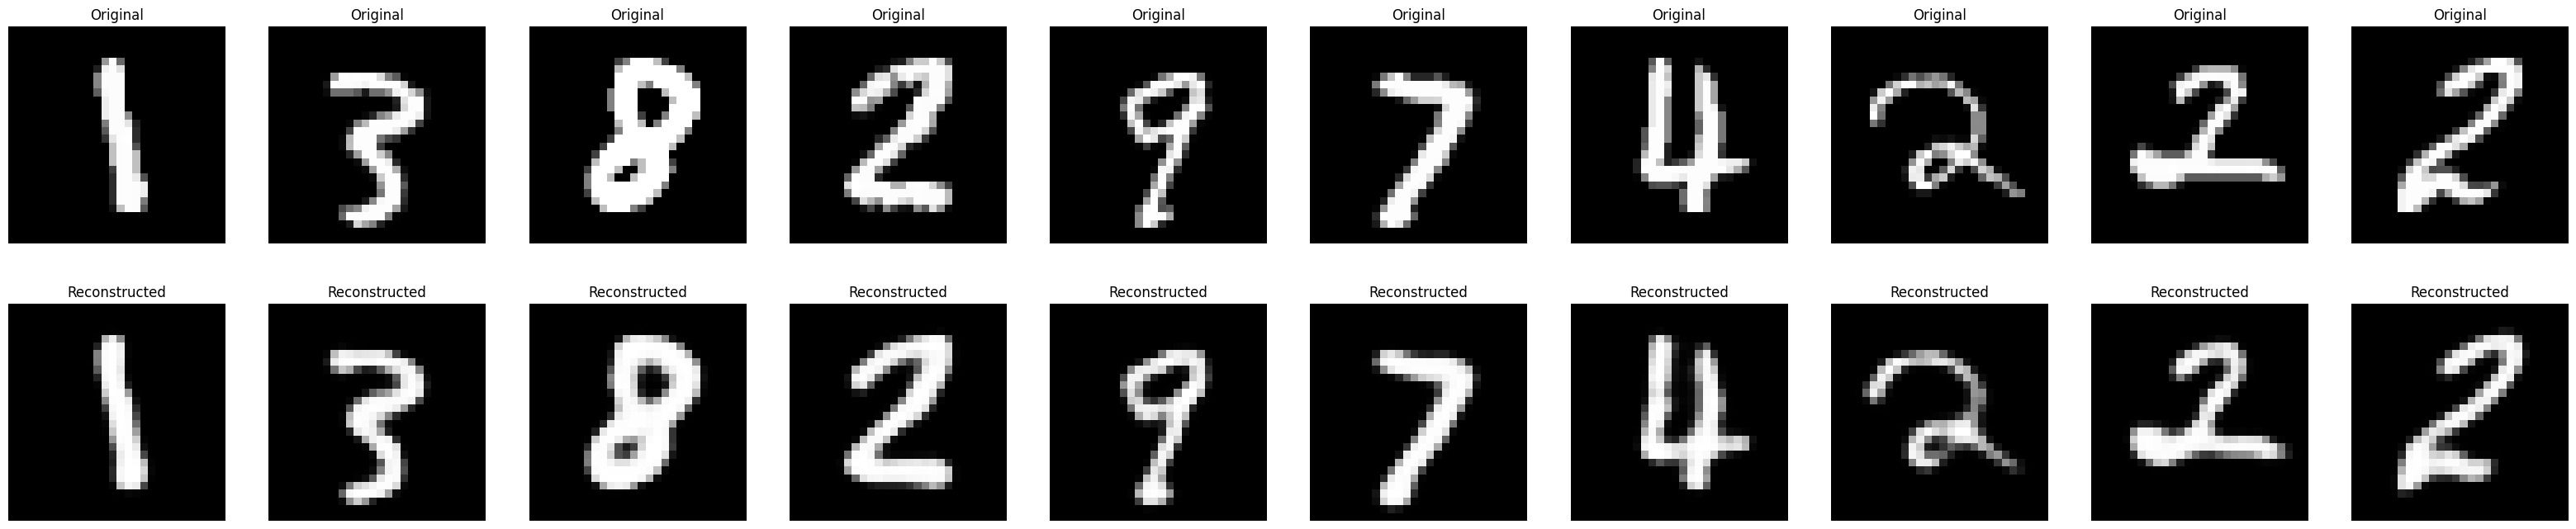

In [ ]:
plot_original_vs_reconstructed(original=X_test, reconstructed=reconstructed_images, columns=10)

As we can see, the autoencoder does a really good job in reconstructing the digits.



---



#2. A classic classifier for MNIST digits

At this point, we introduce a simple, Convolutional classifier for the MNIST dataset. Although classification is not in the main focus of the assignment, we opt for training a classifier. The utter goal is to use it later, when fine tuning some autoencoders. In the following cells, we define the classifier and train it on the train data.

In [ ]:
import tensorflow as tf
import numpy as np


MNIST_classifier = tf.keras.Sequential()
for layer in autoencoder_classic.layers[:7]:
  layer.trainable = False
  MNIST_classifier.add(layer)

MNIST_classifier.add(tf.keras.layers.Flatten())
MNIST_classifier.add(tf.keras.layers.Dense(units=64, activation='relu', name="Dense1"))
MNIST_classifier.add(tf.keras.layers.Dense(units=32, activation='relu', name="Dense2"))
MNIST_classifier.add(tf.keras.layers.Dense(units=10, activation='softmax', name="output"))


print(MNIST_classifier.summary())

MNIST_classifier.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history = MNIST_classifier.fit(
                          X_train, tf.keras.utils.to_categorical(y_train, num_classes=10),
                          epochs=100,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(X_test, tf.keras.utils.to_categorical(y_test, num_classes=10)),
                          verbose="auto"
                        )

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_179 (Conv2D)         (None, 14, 14, 16)        416       
                                                                 
 conv2d_180 (Conv2D)         (None, 7, 7, 8)           3208      
                                                                 
 conv2d_181 (Conv2D)         (None, 4, 4, 8)           1608      
                                                                 
 conv2d_182 (Conv2D)         (None, 4, 4, 8)           1608      
                                                                 
 up_sampling2d_75 (UpSampli  (None, 8, 8, 8)           0         
 ng2D)                                                           
                                                                 
 conv2d_183 (Conv2D)         (None, 8, 8, 8)           1608      
                                                     

We save the classifier to disk, so that we can use it for predictions or get its layers+weights easily.

In [ ]:
MNIST_classifier.save('/gdrive/My Drive/Kaggle/MNIST_classifier.keras')

A simple utility function for pretty printing a classifier evaluation + confusion matrix.

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


def evaluate_classifier(classifier, X_test, y_test):
  predictions = classifier.predict(X_test)
  y_predict = []
  for row in range(len(predictions)):
    y_predict.append(np.argmax(predictions[row]))

  print(f"Classifier accuracy: {accuracy_score(y_true=y_test, y_pred=y_predict)}")
  fig, ax = plt.subplots(figsize=(9,9))
  ax.set_title(f'Confusion matrix for classifier {classifier.name}')
  cm = confusion_matrix(y_test, y_predict)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot(cmap='Purples', ax=ax)

313/313 [==============================] - 1s 4ms/step
Classifier accuracy: 0.9772


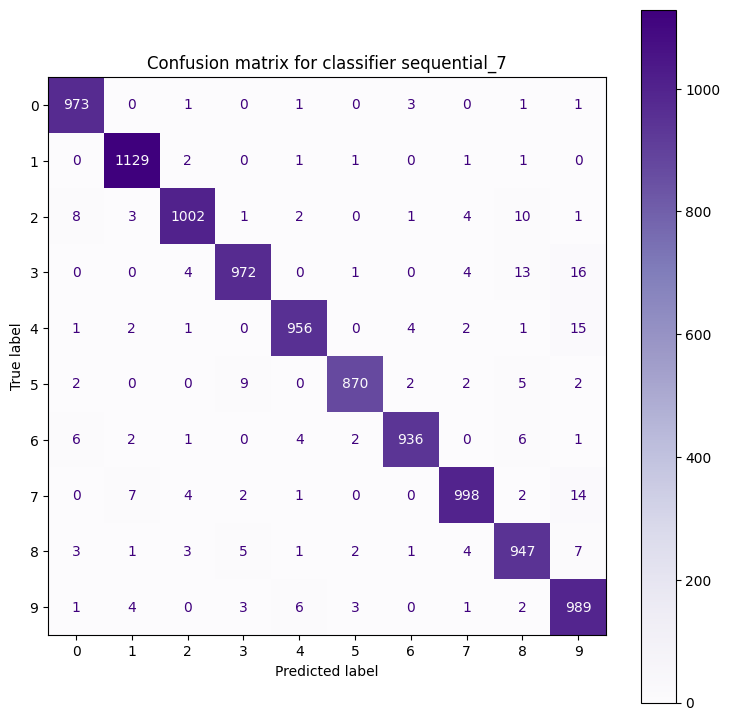

In [ ]:
MNIST_classifier = keras.models.load_model('/gdrive/My Drive/Kaggle/MNIST_classifier.keras')
evaluate_classifier(MNIST_classifier, X_test=X_test, y_test=y_test)

As we can see, the classifier reaches a test accuracy of 97.72 %. Taking a better look at the confusion matrix, we observe that the most frequently misclassified examples are digits 3-8 and 4-9. Such a fact can be easily justified by the resemblance these digits have with one another, especially in cases when the handwriting is "different" than the ordinary or a little bit "sloppy".


---



# 3. Adding some Gaussian noise

Up to that point, we have trained the autoencoder to take as input clear 28x28 MNIST digits, construct a 128-dimensional hidden representation and, from this hidden representation, reconstruct the original image. We now investigate what happens when the input images to the autoencoder have gaussian noise added to them. That is how the noisy images look like:

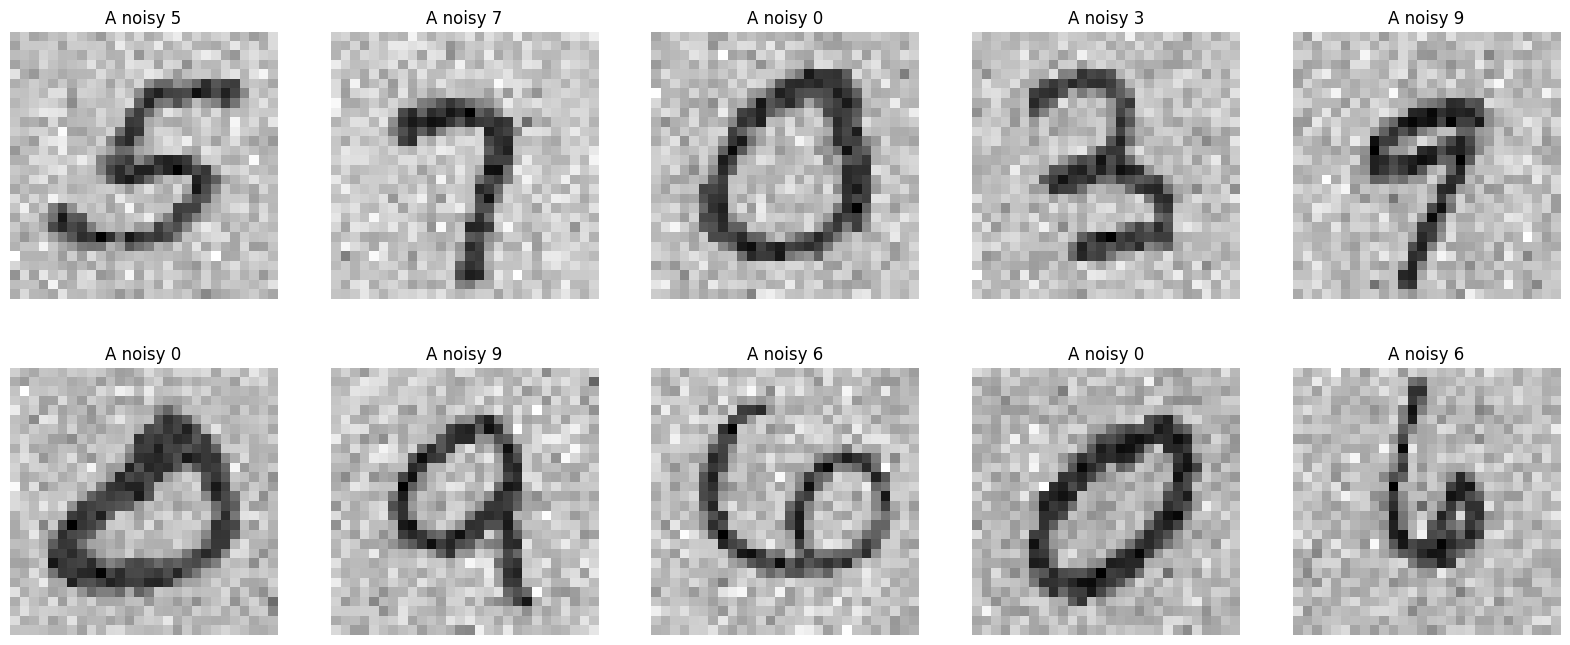

In [ ]:
noise_factor = 0.15

X_train_noisy = X_train + noise_factor * np.random.normal(size=np.shape(X_train))
X_test_noisy =  X_test  + noise_factor * np.random.normal(size=np.shape(X_test))

import matplotlib.pyplot as plt
from numpy.random import randint

rows = 2
columns = 5

random_indices = randint(0, len(X_train_noisy)-1, size=(rows, columns))

fig, ax = plt.subplots(rows, columns, figsize=(columns*4, rows*4))

for row in range(rows):
  for column in range(columns):
    ax[row][column].imshow(X_train_noisy[random_indices[row][column]], cmap='gray_r')
    ax[row][column].set_title(f"A noisy {y_train[random_indices[row][column]]}")
    ax[row][column].axis("off")

Let's see how the autoencoder behaves on the noisy input images. The result is, as expected, bad and distorted. The autoencoder fails to handle the noisy input.

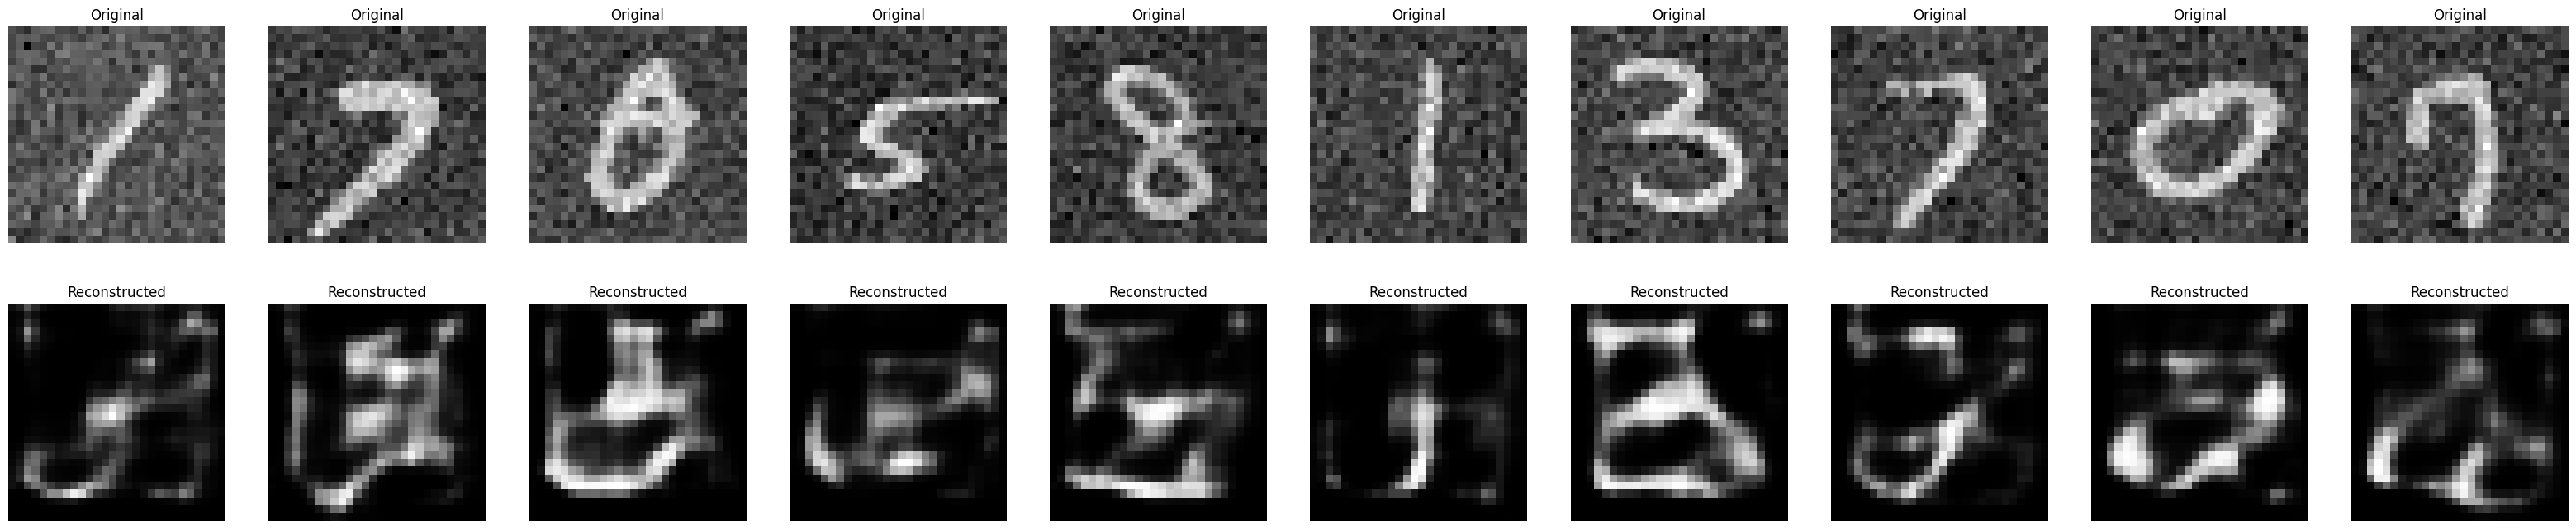

In [ ]:
reconstructed_noisy_images = autoencoder_classic.predict(X_train_noisy)
plot_original_vs_reconstructed(original=X_train_noisy, reconstructed=reconstructed_noisy_images, columns=10)

Having the distorted predictions at hand, it seems quite interesting to investigate how these predictions resemble the original digit! For that purpose, we use the classifier we trained before. In particular, we use the classifier on the distorted autoencoder output and evaluate its accuracy. The final 18.36% is actually poor and stands for the high level of distortion the output images have undergone!

313/313 [==============================] - 1s 4ms/step
Classifier accuracy: 0.1836


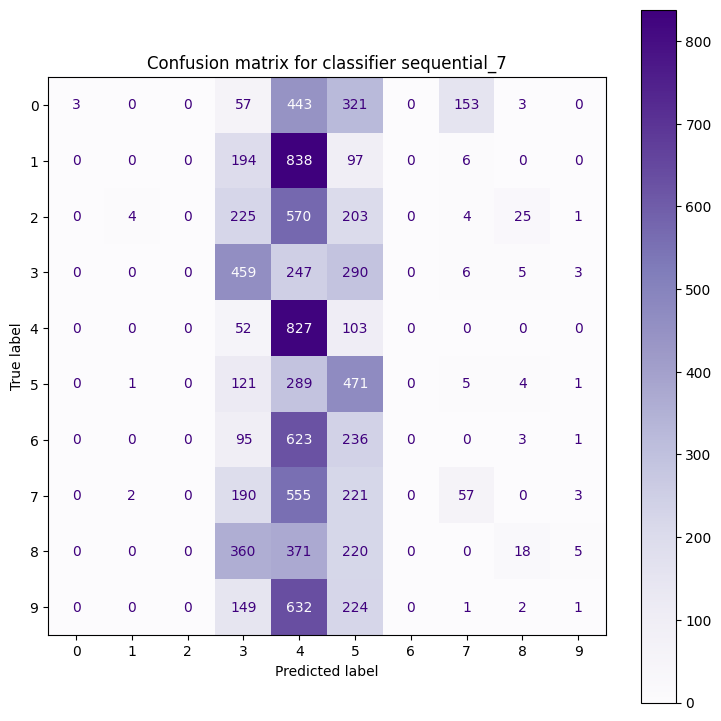

In [ ]:
MNIST_classifier = keras.models.load_model('/gdrive/My Drive/Kaggle/MNIST_classifier.keras')
evaluate_classifier(MNIST_classifier, X_test=X_test_noisy, y_test=y_test)

#4. Solution: An autoencoder for denoising

A possible solution to the above problem would be to train an autoencoder to deal with that specific problem: denoising noisy input!

We keep the same architecture with Convolutional Layers as before. The only difference is this time we give the noisy images as input to the autoencoder and ask for original image reconstruction, i.e. the autoencoder is trained to recostruct the original image without the noise.

We train the autoencoder for 100 epochs again, reaching an accuracy of 81.25 %, which is really close to 81.44 % we reached with the classic reconstruction autoencoder.

In [ ]:
# Defining the autoencoder
denoising_autoencoder = get_autoencoder_for_MNIST(name="MNIST_autoencoder_for_denoising")

# Training the autoencoder
denoising_autoencoder.fit(
                          X_train_noisy, X_train,
                          epochs=100,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(X_test_noisy, X_test),
                          verbose="auto"
                        )

# Using the autoencoder for reconstruction
reconstructed_images = denoising_autoencoder.predict(X_test_noisy)

Epoch 1/100
469/469 [==============================] - 5s 7ms/step - loss: 0.2246 - accuracy: 0.7969 - val_loss: 0.1539 - val_accuracy: 0.8014
Epoch 2/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1428 - accuracy: 0.8046 - val_loss: 0.1339 - val_accuracy: 0.8067
Epoch 3/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1302 - accuracy: 0.8072 - val_loss: 0.1252 - val_accuracy: 0.8072
Epoch 4/100
469/469 [==============================] - 4s 8ms/step - loss: 0.1239 - accuracy: 0.8084 - val_loss: 0.1203 - val_accuracy: 0.8083
Epoch 5/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1199 - accuracy: 0.8091 - val_loss: 0.1173 - val_accuracy: 0.8082
Epoch 6/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1174 - accuracy: 0.8096 - val_loss: 0.1154 - val_accuracy: 0.8083
Epoch 7/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1155 - accuracy: 0.8099 - val_loss: 0.1134 - val_accuracy: 0.8088

As we did before, we use the autoencoder (denoised) output as input to the classifier we have trained to evaluate the denoising autoencoder. As we can see, the classifier accuracy drops from 97.72 to 95.09 % for the reconstructed images. Taking into account, however, that the digits are denoised, without the autoencoder to have seen the original images, the percentage is pretty good. The most frequent misclassification this time is again between digtis 4 and 9, which is totally justifiable, since the noise can easily make these two digits look alike.

313/313 [==============================] - 1s 2ms/step
Classifier accuracy: 0.9509


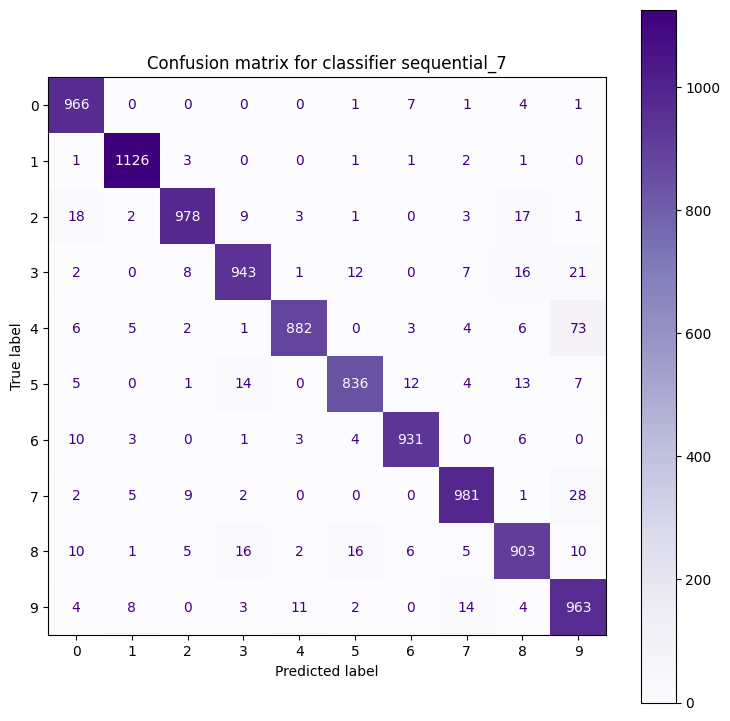

In [ ]:
MNIST_classifier = keras.models.load_model('/gdrive/My Drive/Kaggle/MNIST_classifier.keras')
evaluate_classifier(MNIST_classifier, X_test=reconstructed_images, y_test=y_test)

A simple utility function for pretty printing/plotting.

In [ ]:
import matplotlib.pyplot as plt
from numpy.random import randint


def plot_noisy_vs_reconstructed_vs_original(noisy, reconstructed, original, columns=5):
  rows=3
  random_indices = randint(0, len(original)-1, size=columns)

  fig, ax = plt.subplots(rows, columns, figsize=(columns*4, rows*4))

  for index, random_index in enumerate(random_indices):
    ax[0][index].imshow(noisy[random_index], cmap='gray')
    ax[0][index].set_title("Noisy")
    ax[0][index].axis("off")

    ax[1][index].imshow(reconstructed[random_index], cmap='gray')
    ax[1][index].set_title("Reconstructed")
    ax[1][index].axis("off")

    ax[2][index].imshow(original[random_index], cmap='gray')
    ax[2][index].set_title("Original")
    ax[2][index].axis("off")

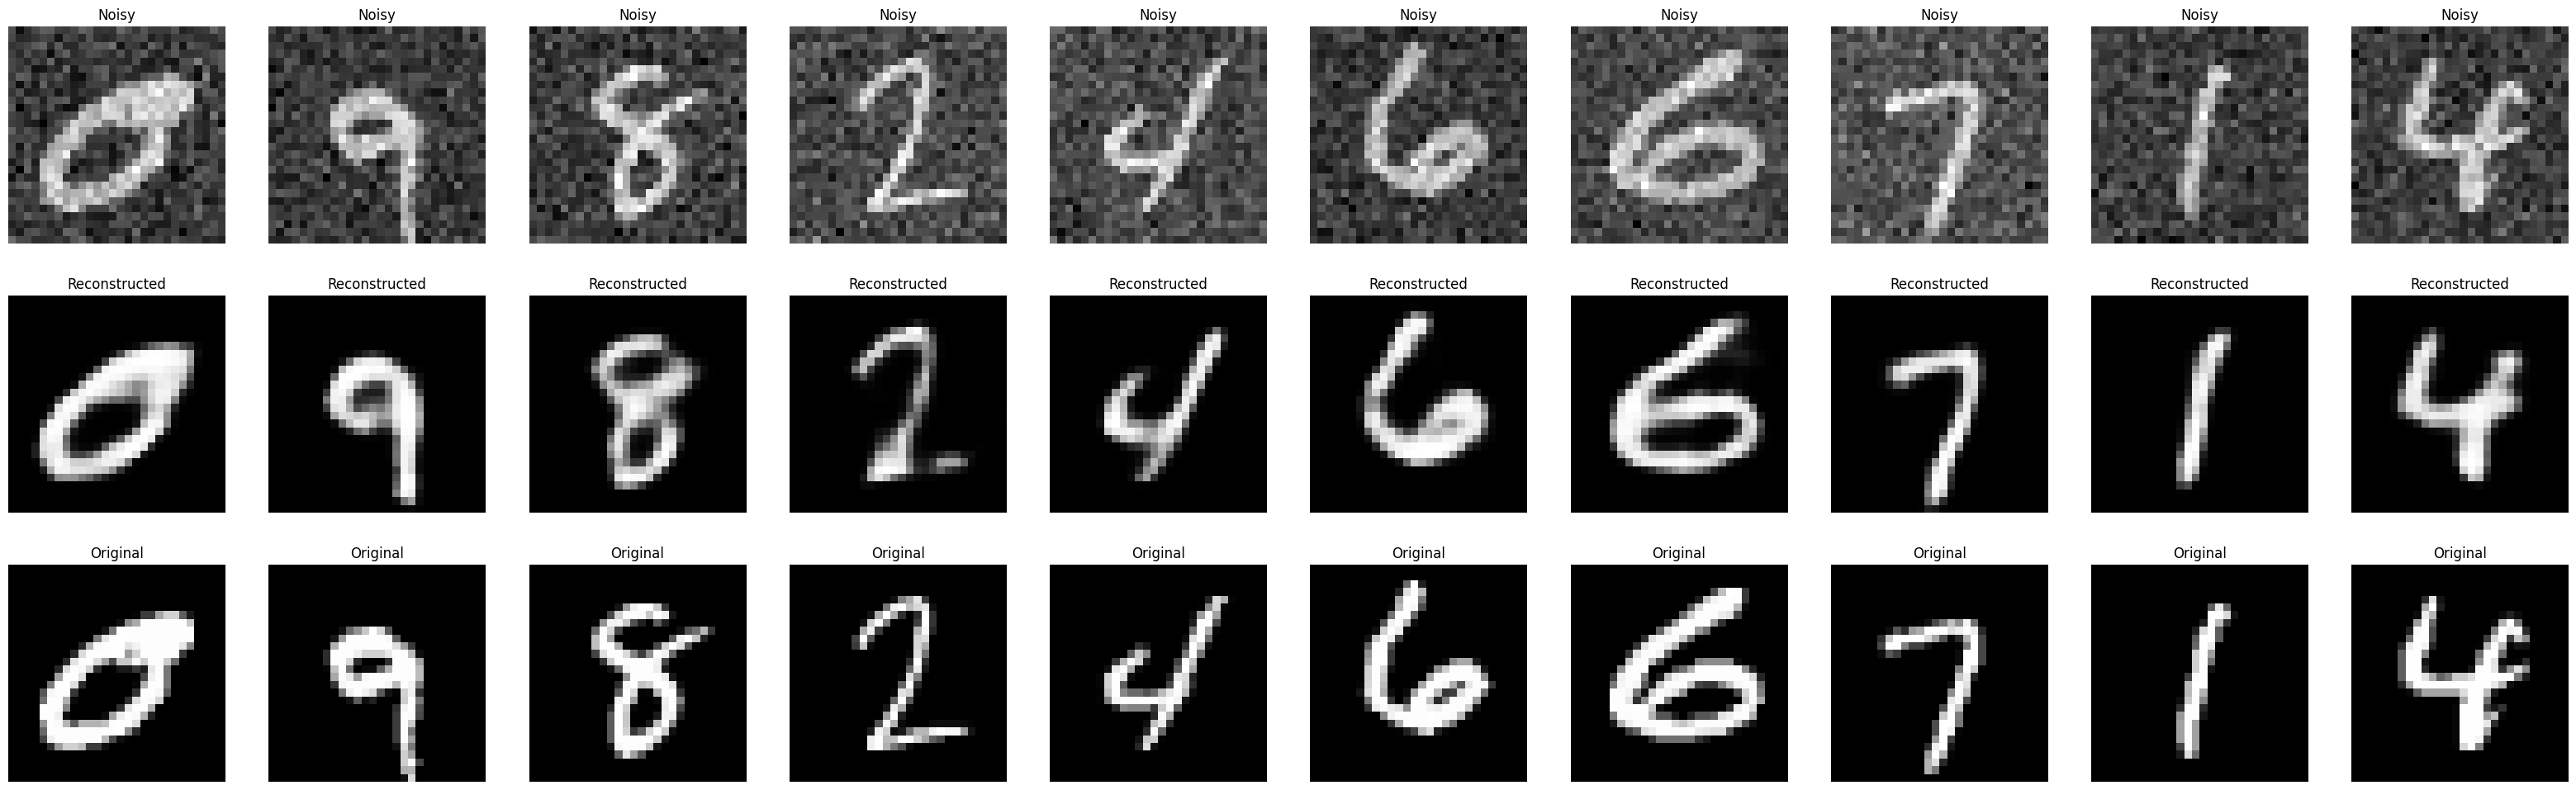

In [ ]:
plot_noisy_vs_reconstructed_vs_original(noisy=X_test_noisy, reconstructed=reconstructed_images, original=X_test, columns=10)

As we can see, the reconstructed images are pretty close to the original ones!


---



#5. Another solution: PCA for denoising

Another solution to the above problem (noisy input) can be the use of PCA on the noisy images, to keep only several principal components (eigenvectors) of the noisy image and using this representation to reconstruct the original one, aiming for denoising. In the following cell, we perform PCA on the noisy train data, keeping 64 components, and, then, we try to denoise the images via inverse PCA transformation. The results are plotted below.

Shape of X_train_noisy_flattened: (60000, 784)
Shape of X_test_noisy_flattened : (10000, 784)


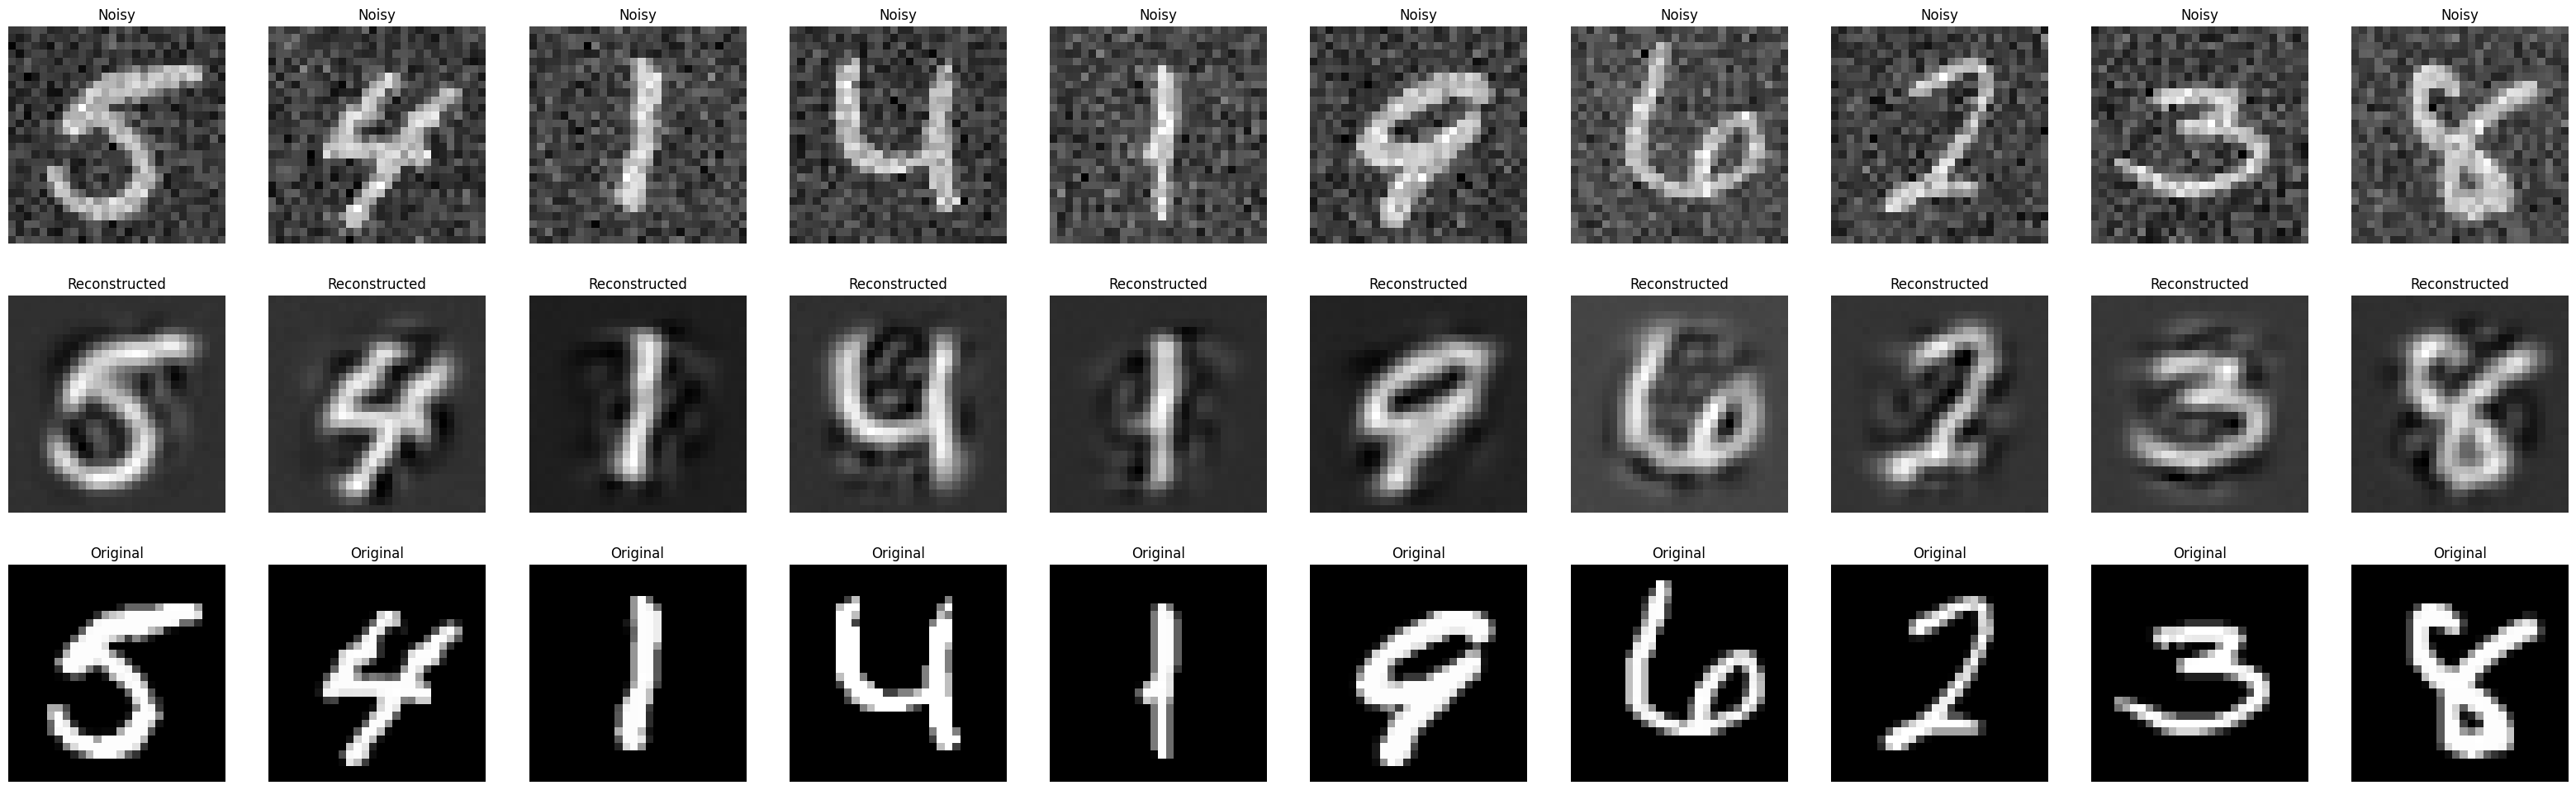

In [ ]:
from sklearn.decomposition import PCA, KernelPCA

X_train_noisy_flattened = np.reshape(a=X_train_noisy, newshape=(-1, 28*28))
X_test_noisy_flattened  = np.reshape(a=X_test_noisy , newshape=(-1, 28*28))

print(f"Shape of X_train_noisy_flattened: {np.shape(X_train_noisy_flattened)}")
print(f"Shape of X_test_noisy_flattened : {np.shape(X_test_noisy_flattened)}")

pca = PCA(n_components=64)
pca.fit(X_train_noisy_flattened)
reconstructed_images = pca.inverse_transform(pca.transform(X_test_noisy_flattened))
reconstructed_images = np.reshape(reconstructed_images, newshape=(-1, 28, 28))

plot_noisy_vs_reconstructed_vs_original(noisy=X_test_noisy, reconstructed=reconstructed_images, original=X_test, columns=10)

The reconstruction-denoising with PCA seems to be not as good as the one with the previous autoencoder. Apart from the human-eye evaluation, we can, again, use the classifier to see how well it can perform on the output images.

313/313 [==============================] - 1s 3ms/step
Classifier accuracy: 0.4639


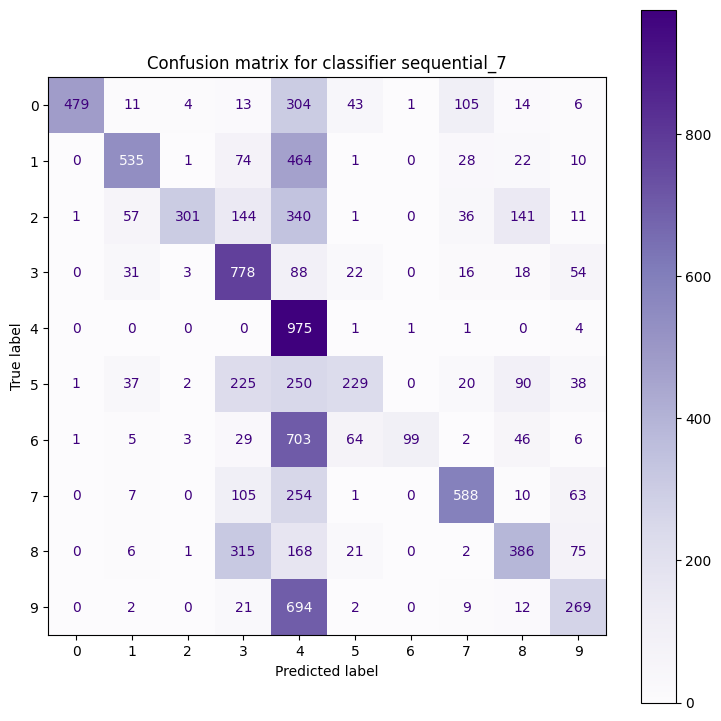

In [ ]:
MNIST_classifier = keras.models.load_model('/gdrive/My Drive/Kaggle/MNIST_classifier.keras')
evaluate_classifier(MNIST_classifier, X_test=reconstructed_images, y_test=y_test)

As expected, the accuracy of the classifier drops from 0.9772 to 0.4639 (autoencoder respective evaluation was 0.9509). However, it is significantly better than 0.1836 that the classifier answers correct in the first place on the noisy input.

#6. An unexpected solution: training an autoencoder to reproduce noise!

Up to that point, we have used classic techniques to address the problem of noisy input digit images: PCA and denoising autoencoding. In this section, we resort to a rather unexpected, yet well-performing "solution". The most intriguing part of the solution is the fact that it does not even try to solve the problem, although it manages to do at the end!

More specifically, we define and train an autoencoder with the architecture we have used throughout this assignment (Convolutional with 3 layers in encoder and decoder). However, this time, we give as input the noisy train images and ask from the autoencoder to reconstruct the input images, i.e. the noisy ones!


In [ ]:
# Defining the autoencoder
autoencoder_noisy_reconstruction = get_autoencoder_for_MNIST(name="MNIST_autoencoder_noisy_reconstruction")

# Training the autoencoder
autoencoder_noisy_reconstruction.fit(
                                      X_train_noisy, X_train_noisy,
                                      epochs=100,
                                      batch_size=128,
                                      shuffle=True,
                                      validation_data=(X_test_noisy, X_test),
                                      verbose="auto"
                                    )

# Using the autoencoder for reconstruction
reconstructed_images = autoencoder_noisy_reconstruction.predict(X_test_noisy)

Epoch 1/100
469/469 [==============================] - 5s 7ms/step - loss: 0.2272 - accuracy: 0.0000e+00 - val_loss: 0.1598 - val_accuracy: 0.7987
Epoch 2/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1225 - accuracy: 0.0000e+00 - val_loss: 0.1476 - val_accuracy: 0.8025
Epoch 3/100
469/469 [==============================] - 4s 9ms/step - loss: 0.0966 - accuracy: 0.0000e+00 - val_loss: 0.1409 - val_accuracy: 0.8041
Epoch 4/100
469/469 [==============================] - 3s 7ms/step - loss: 0.0804 - accuracy: 0.0000e+00 - val_loss: 0.1362 - val_accuracy: 0.8059
Epoch 5/100
469/469 [==============================] - 3s 7ms/step - loss: 0.0715 - accuracy: 0.0000e+00 - val_loss: 0.1332 - val_accuracy: 0.8068
Epoch 6/100
469/469 [==============================] - 3s 7ms/step - loss: 0.0656 - accuracy: 0.0000e+00 - val_loss: 0.1332 - val_accuracy: 0.8069
Epoch 7/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0609 - accuracy: 0.0000e+00 - val_loss: 0

In [ ]:
autoencoder_noisy_reconstruction.save('/gdrive/My Drive/Kaggle/autoencoder_noisy_noisy.keras')

The results are rather unexpected! The autoencoder TOTALLY fails to reproduce the noisy input! Nevertheless, it achieves something we never asked for: denoising of the input images!

As a matter of fact, the autoencoder fails to "learn" the pattern of noise, since it is gaussian (random)! So the autoencoder fails to reconstruct the noisy image. What it manages to recostruct (learn) is the pattern of the digits, filtering out the noise. The following images show the input, output and original digits.

313/313 [==============================] - 1s 3ms/step


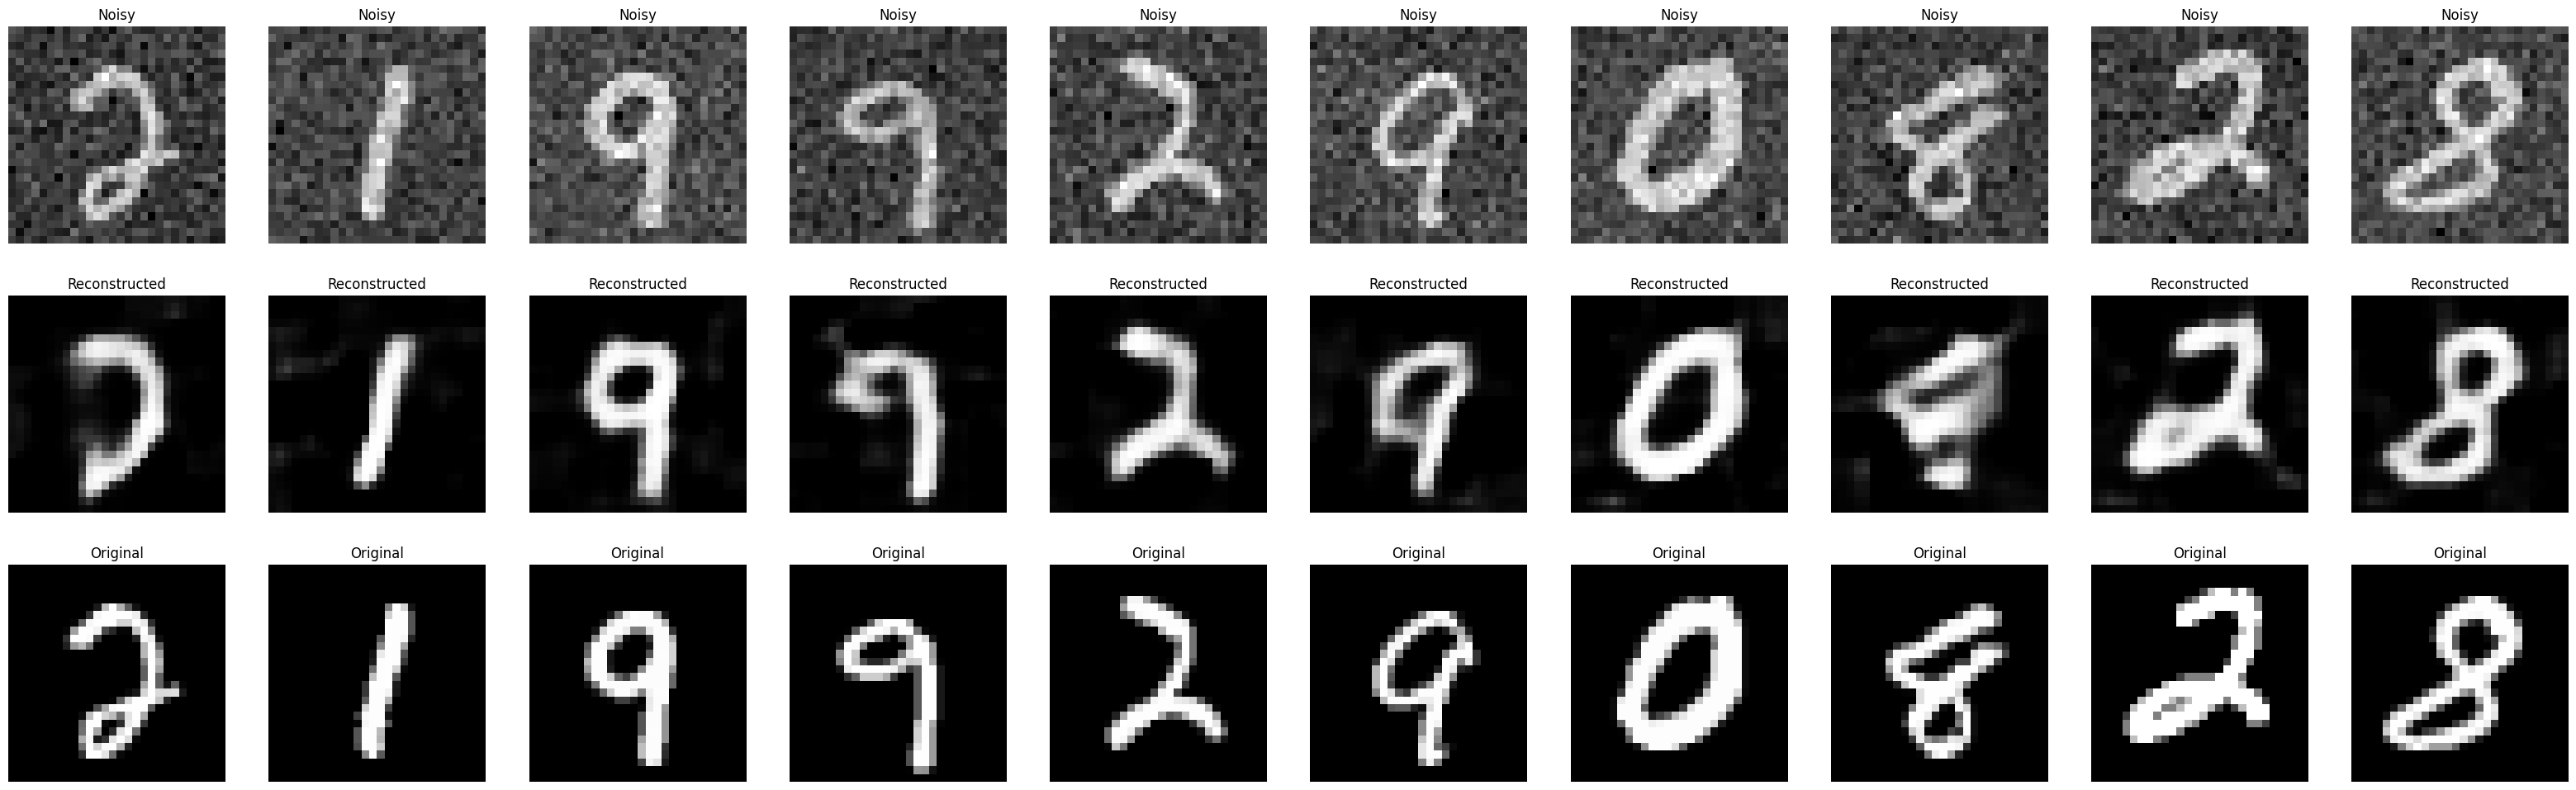

In [ ]:
plot_noisy_vs_reconstructed_vs_original(noisy=X_test_noisy, reconstructed=reconstructed_images, original=X_test, columns=10)

313/313 [==============================] - 1s 2ms/step


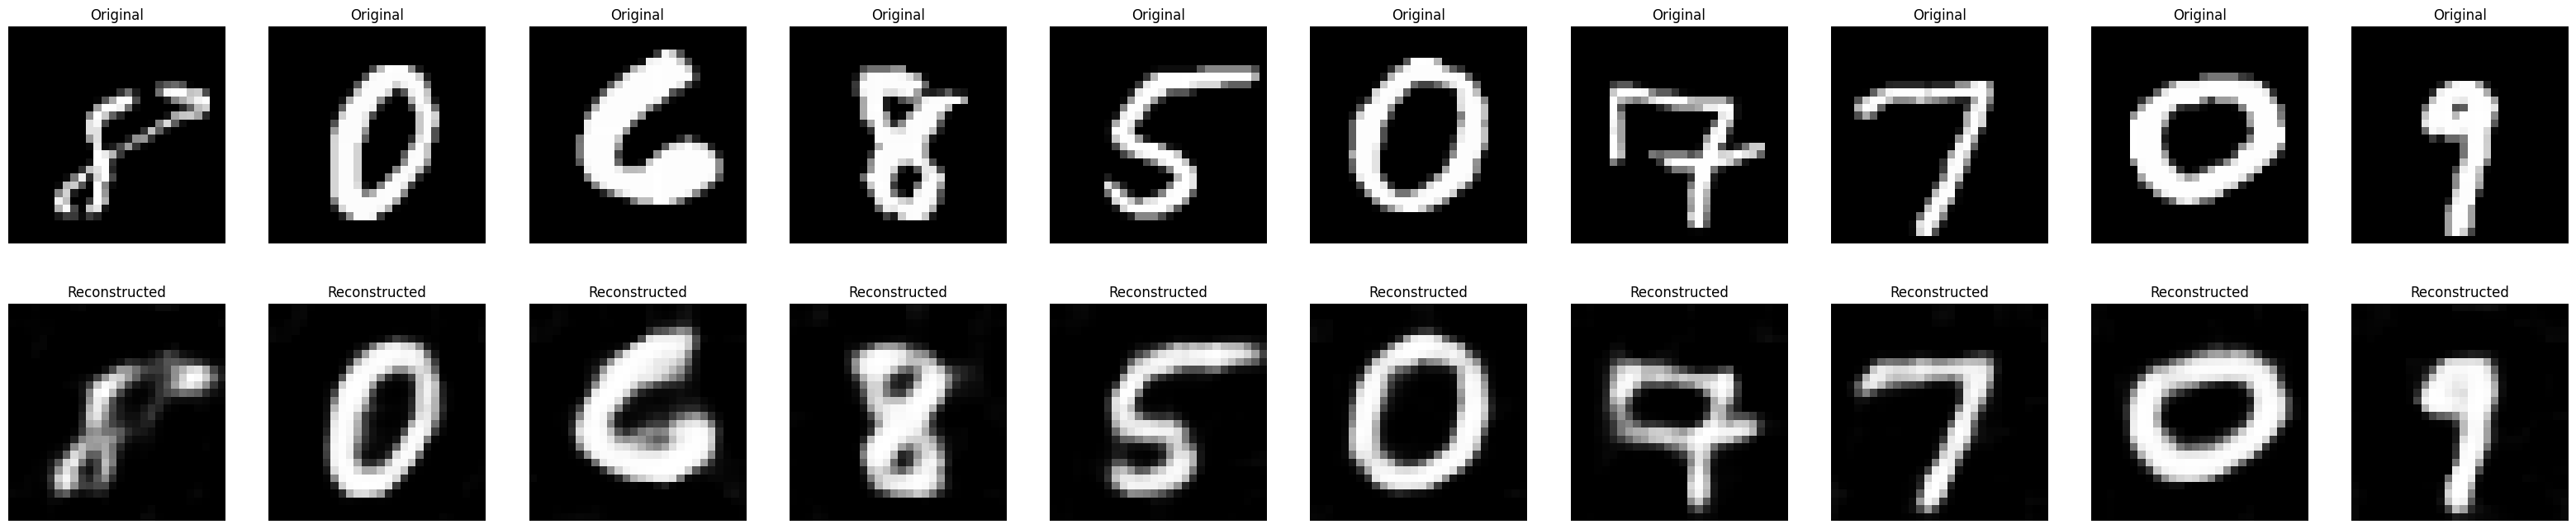

In [ ]:
reconstructed_images = autoencoder_noisy_reconstruction.predict(X_test)
plot_original_vs_reconstructed(reconstructed=reconstructed_images, original=X_test, columns=10)

313/313 [==============================] - 1s 2ms/step
Classifier accuracy: 0.9216


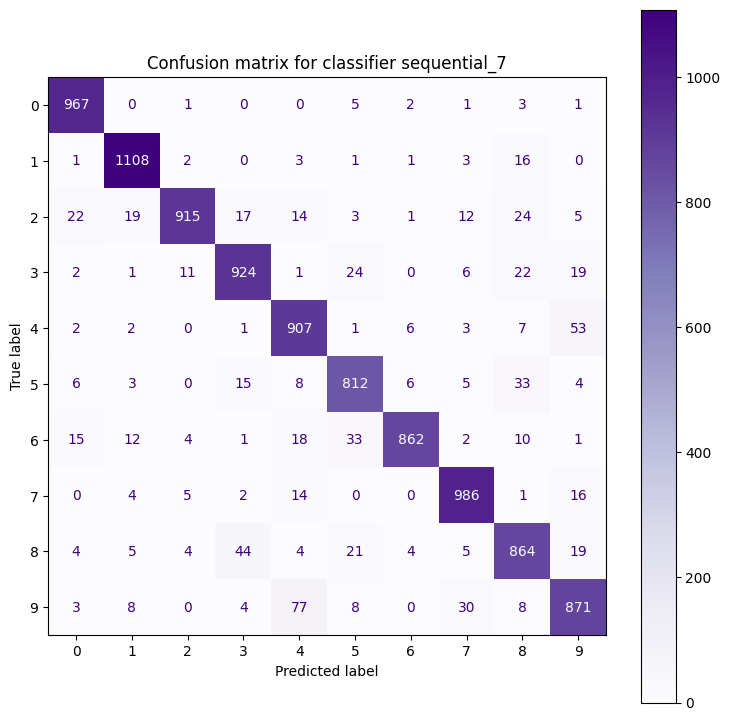

In [ ]:
MNIST_classifier = keras.models.load_model('/gdrive/My Drive/Kaggle/MNIST_classifier.keras')
evaluate_classifier(MNIST_classifier, X_test=reconstructed_images, y_test=y_test)

We evaluate the reconstruction using the classifier we trained. As we can see, the classifier achieves an accuracy of 0.926 (initial 0.9772, PCA 0.4639).

---


#7. An autoencoder for reconstructing next digit

Having covered in detail different variations of reconstruction and denoising, our next step is to do something a little bit more challenging: Develop an autoencoder NN that, given a digit image, reconstructs an image that depicts the next digit. For example, if the input image shows a 7, the autoencoder should produce an 8, etc.

For that purpose, we create an auxiliary data structure that contains the train example indices separated for each digit, both for the train and the test set.

```
'1' -> {8, 12, 56, ...}

'2' -> {0, 9, 123, ...}

.

.
```


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

digit_indices_train = {str(digit): [] for digit in range(10)}
digit_indices_test  = {str(digit): [] for digit in range(10)}

for index, train_label in enumerate(y_train):
  digit_indices_train[str(train_label)].append(index)

y_train_next = []

for train_label in y_train:
  y_train_next.append(X_train[np.random.choice(a=digit_indices_train[str((train_label + 1) % 10)])])
y_train_next = np.array(y_train_next)


for index, test_label in enumerate(y_test):
  digit_indices_test[str(test_label)].append(index)

y_test_next = []

for test_label in y_test:
  y_test_next.append(X_test[np.random.choice(a=digit_indices_test[str((test_label + 1) % 10)])])
y_test_next = np.array(y_test_next)


print(np.shape(y_train_next))
print(np.shape(X_train))
print(np.shape(y_test_next))
print(np.shape(X_test))

(60000, 28, 28)
(60000, 28, 28)
(10000, 28, 28)
(10000, 28, 28)


## Variation 7a: Different output digit example for every output

In this first variation, we opt for training an autoencoder that takes every time a different digit example as desired output. That means every time the desired output is e.g. 4, a randomly selected 4 is given to the autoencoder. We train the autoencoder (same architecture again) for 100 epochs and plot the results.

In [ ]:
# Defining the autoencoder
autoencoder_reconstruct_next = get_autoencoder_for_MNIST(name="MNIST_autoencoder_reconstruct_next")

# Training the autoencoder
autoencoder_reconstruct_next.fit(
                                      X_train, y_train_next,
                                      epochs=100,
                                      batch_size=128,
                                      shuffle=True,
                                      validation_data=(X_test, y_test_next),
                                      verbose="auto"
                                    )

# Using the autoencoder for reconstruction
reconstructed_images = autoencoder_reconstruct_next.predict(X_test)

Epoch 1/100
469/469 [==============================] - 7s 9ms/step - loss: 0.2780 - accuracy: 0.8047 - val_loss: 0.2572 - val_accuracy: 0.8000
Epoch 2/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2489 - accuracy: 0.7984 - val_loss: 0.2424 - val_accuracy: 0.7935
Epoch 3/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2390 - accuracy: 0.7936 - val_loss: 0.2364 - val_accuracy: 0.7891
Epoch 4/100
469/469 [==============================] - 4s 8ms/step - loss: 0.2348 - accuracy: 0.7924 - val_loss: 0.2329 - val_accuracy: 0.7918
Epoch 5/100
469/469 [==============================] - 4s 9ms/step - loss: 0.2328 - accuracy: 0.7919 - val_loss: 0.2313 - val_accuracy: 0.7914
Epoch 6/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2315 - accuracy: 0.7916 - val_loss: 0.2308 - val_accuracy: 0.7931
Epoch 7/100
469/469 [==============================] - 3s 7ms/step - loss: 0.2307 - accuracy: 0.7914 - val_loss: 0.2295 - val_accuracy: 0.7899

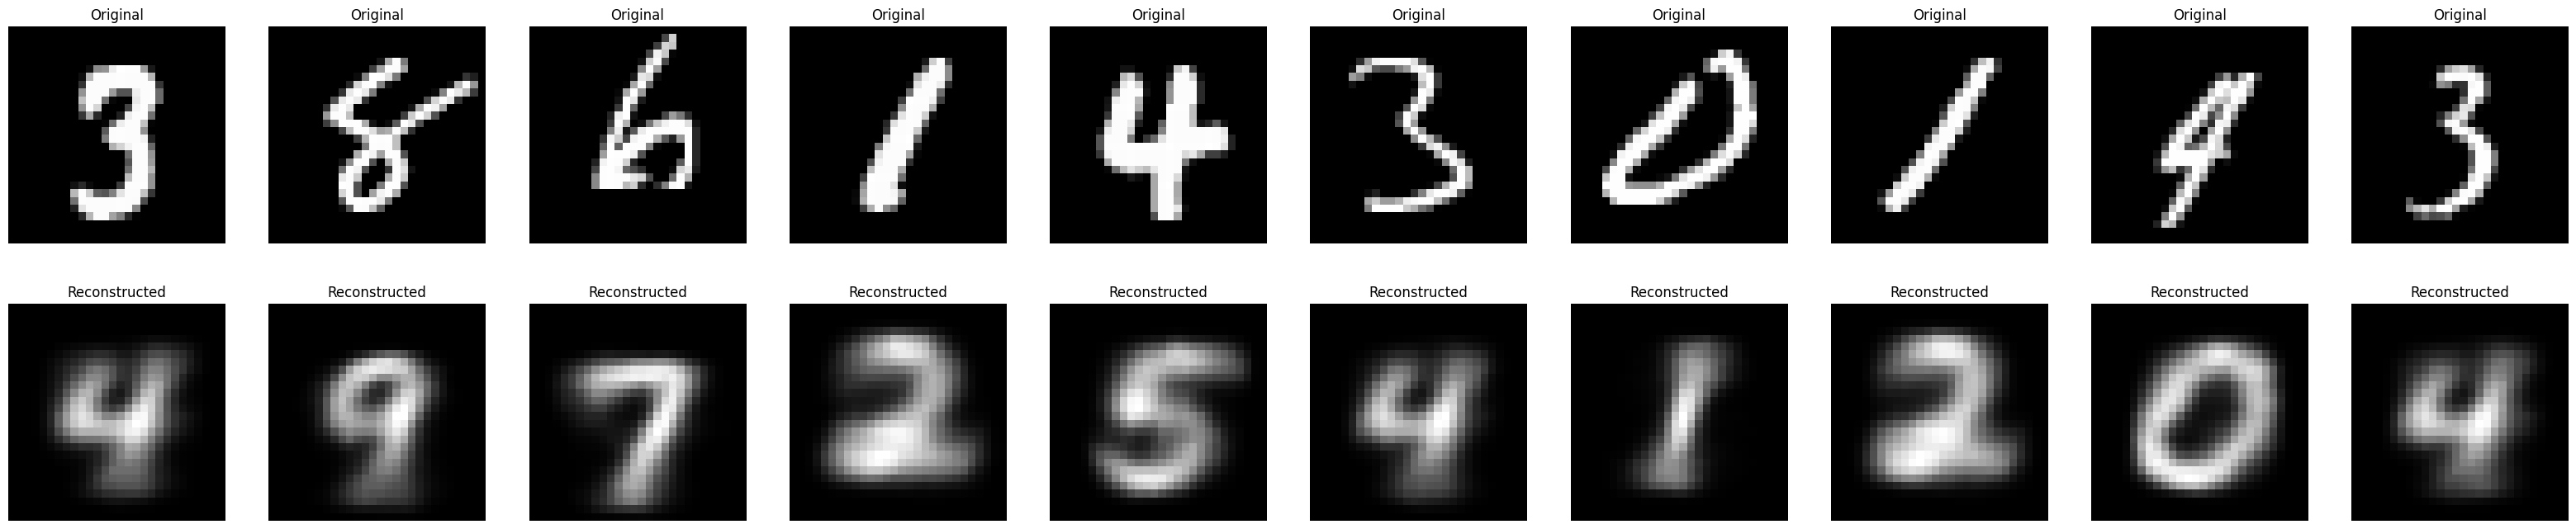

In [ ]:
plot_original_vs_reconstructed(reconstructed=reconstructed_images, original=X_test, columns=10)

As we can see, the output is a little bit blurry. That is completely justifiable: the autoencoder "learns" to reproduce the average 1, 2, 3, etc., and not a specific one!

We evaluate the reconstruction again using the already trained MNIST classifier. The final accuracy is 0.9573 (initial was 0.9772).

313/313 [==============================] - 1s 2ms/step
Classifier accuracy: 0.9573


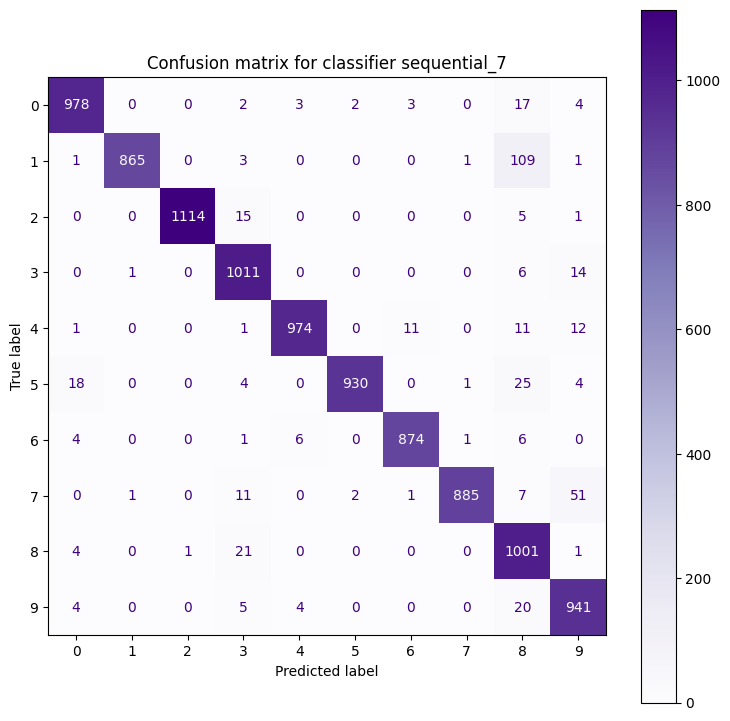

In [ ]:
MNIST_classifier = keras.models.load_model('/gdrive/My Drive/Kaggle/MNIST_classifier.keras')
evaluate_classifier(MNIST_classifier, X_test=reconstructed_images, y_test=((y_test + 1) % 10))

## Variation 7b: Same target for every input digit

In this second variation, we investigate the autoencoder behavior when the target image is always a single image for each input digit. That means every time the desired output is e.g. 4, the same 4 is given as desired output to the autoencoder training. We train the autoencoder for 100 epochs and plot the results.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

digit_indices_train = {str(digit): [] for digit in range(10)}
digit_indices_test  = {str(digit): [] for digit in range(10)}

for index, train_label in enumerate(y_train):
  digit_indices_train[str(train_label)].append(index)

y_train_next = []

for train_label in y_train:
  y_train_next.append(X_train[digit_indices_train[str((train_label + 1) % 10)][0]])
y_train_next = np.array(y_train_next)


for index, test_label in enumerate(y_test):
  digit_indices_test[str(test_label)].append(index)

y_test_next = []

for test_label in y_test:
  y_test_next.append(X_test[digit_indices_test[str((test_label + 1) % 10)][0]])
y_test_next = np.array(y_test_next)


print(np.shape(y_train_next))
print(np.shape(X_train))
print(np.shape(y_test_next))
print(np.shape(X_test))

(60000, 28, 28)
(60000, 28, 28)
(10000, 28, 28)
(10000, 28, 28)


In [ ]:
# Defining the autoencoder
autoencoder_reconstruct_next = get_autoencoder_for_MNIST(name="MNIST_autoencoder_reconstruct_next_v2")

# Training the autoencoder
autoencoder_reconstruct_next.fit(
                                      X_train, y_train_next,
                                      epochs=100,
                                      batch_size=128,
                                      shuffle=True,
                                      validation_data=(X_test, y_test_next),
                                      verbose="auto"
                                    )

# Using the autoencoder for reconstruction
reconstructed_images = autoencoder_reconstruct_next.predict(X_test)

313/313 [==============================] - 1s 4ms/step


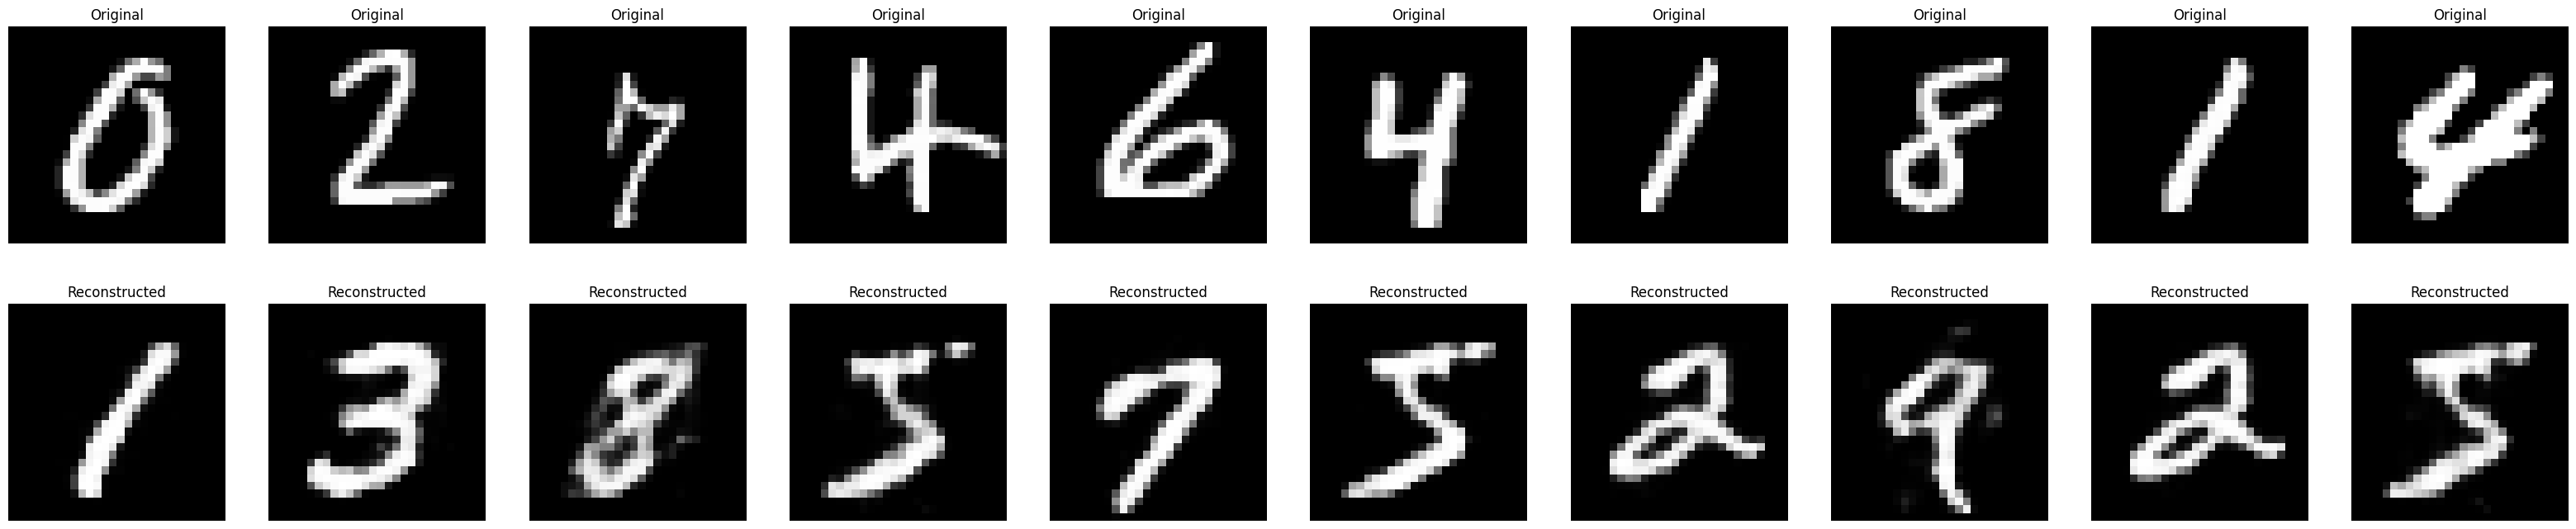

In [ ]:
plot_original_vs_reconstructed(reconstructed=reconstructed_images, original=X_test, columns=10)

This time the output digits are clear and straightforward. Such a result is rather expected, since the target was the same for each digit. As we can see, every time the autoencoder needs to reconstructs a 2, for example, the same 2 is reconstructed.

The reconstructed digits are recognized with an accuracy of 0.9534 by the trained classifier, wich is slightly less than 0.9573 we achieved with variation 7a.

313/313 [==============================] - 1s 2ms/step
Classifier accuracy: 0.9534


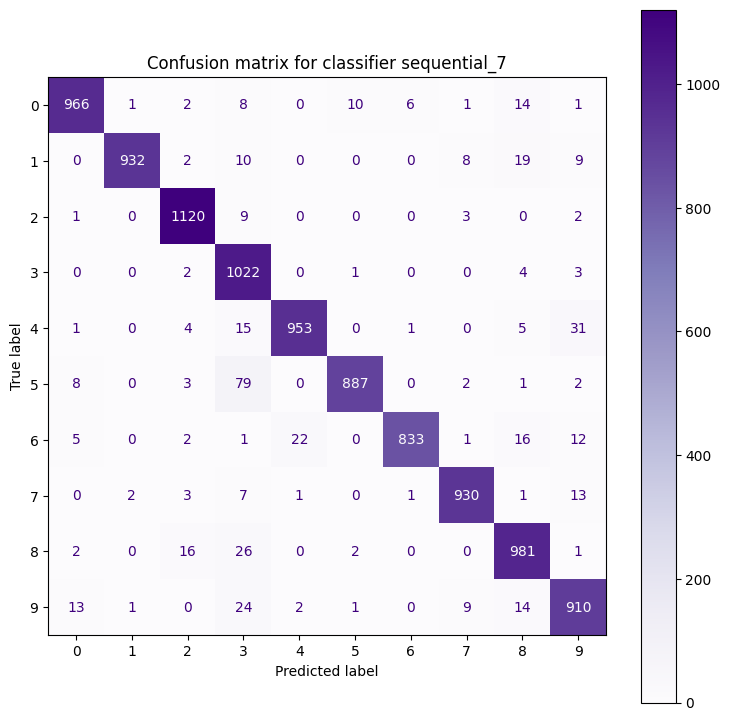

In [ ]:
MNIST_classifier = keras.models.load_model('/gdrive/My Drive/Kaggle/MNIST_classifier.keras')
evaluate_classifier(MNIST_classifier, X_test=reconstructed_images, y_test=((y_test + 1) % 10))

## Variation 7c: Pluging a "frozen" (non trainable) classifier at the end of the autoencoder

In this third variation, we take it one step further: we plug an MNIST classifier at the end of the autoencoder and train the network. The MNIST classifier is fixed, i.e. its weights are not changed during training. The idea behind such a choice is to "force" the autoencoder produce results that can be classified correctly by the classifier.


In [ ]:
MNIST_classifier = keras.models.load_model('/gdrive/My Drive/Kaggle/MNIST_classifier.keras')


# ---------------------------------- INPUT ----------------------------------
input = keras.Input(shape=(28, 28, 1), name="input")

# --------------------------------- ENCODER ----------------------------------
x = layers.Conv2D(16, (5, 5), activation='relu', padding='same', strides=(2, 2), trainable=True, weights=autoencoder_reconstruct_next.layers[1].get_weights())(input)
x = layers.Conv2D(8, (5, 5), activation='relu', padding='same', trainable=True, weights=autoencoder_reconstruct_next.layers[2].get_weights())(x)
x = layers.Conv2D(8, (5, 5), activation='relu', padding='same', strides=(2, 2), trainable=True, weights=autoencoder_reconstruct_next.layers[3].get_weights())(x)
encoded = layers.Conv2D(8, (5, 5), activation='relu', padding='same', strides=(2, 2), trainable=True, weights=autoencoder_reconstruct_next.layers[4].get_weights())(x)

# --------------------------------- DECODER ----------------------------------
x = layers.Conv2D(8, (5, 5), activation='relu', padding='same', trainable=True, weights=autoencoder_reconstruct_next.layers[5].get_weights())(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (5, 5), activation='relu', padding='same', trainable=True, weights=autoencoder_reconstruct_next.layers[7].get_weights())(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', trainable=True, weights=autoencoder_reconstruct_next.layers[9].get_weights())(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (5, 5), activation='sigmoid', padding='same', trainable=True, weights=autoencoder_reconstruct_next.layers[11].get_weights())(x)

# -------------------------------- CLASSIFIER ----------------------------------
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same', trainable=False, weights=MNIST_classifier.layers[0].get_weights())(decoded)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same', trainable=False, weights=MNIST_classifier.layers[2].get_weights())(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same', trainable=False, weights=MNIST_classifier.layers[4].get_weights())(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Flatten()(encoded)
x = layers.Dense(units=64, activation='relu', name="Dense1", trainable=False, weights=MNIST_classifier.layers[7].get_weights())(x)
x = layers.Dense(units=32, activation='relu', name="Dense2", trainable=False, weights=MNIST_classifier.layers[8].get_weights())(x)
output = layers.Dense(units=10, activation='softmax', name="output", trainable=False, weights=MNIST_classifier.layers[9].get_weights())(x)

model_fine_tuning = keras.models.Model(input, output)
autoencoder_reconstruct_next_v3 = keras.models.Model(input, decoded)
model_fine_tuning.compile(optimizer=keras.optimizers.SGD(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# Training the autoencoder
model_fine_tuning.fit(
                                      X_train, keras.utils.to_categorical((y_train + 1) % 10, num_classes=10),
                                      epochs=50,
                                      batch_size=128,
                                      shuffle=True,
                                      validation_data=(X_test, keras.utils.to_categorical((y_test + 1) % 10, num_classes=10)),
                                      verbose="auto"
                                    )

# Using the autoencoder for reconstruction
reconstructed_images = autoencoder_reconstruct_next_v3.predict(X_test)

Epoch 1/50
469/469 [==============================] - 4s 7ms/step - loss: 0.0191 - accuracy: 0.9958 - val_loss: 0.0738 - val_accuracy: 0.9829
Epoch 2/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0189 - accuracy: 0.9958 - val_loss: 0.0747 - val_accuracy: 0.9831
Epoch 3/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0187 - accuracy: 0.9958 - val_loss: 0.0745 - val_accuracy: 0.9834
Epoch 4/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0186 - accuracy: 0.9959 - val_loss: 0.0747 - val_accuracy: 0.9831
Epoch 5/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0184 - accuracy: 0.9958 - val_loss: 0.0737 - val_accuracy: 0.9827
Epoch 6/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0183 - accuracy: 0.9960 - val_loss: 0.0738 - val_accuracy: 0.9831
Epoch 7/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0181 - accuracy: 0.9960 - val_loss: 0.0735 - val_accuracy: 0.9829
Epoch 

The result is unexpectedly bad! Althouth the hybrid autoencoder-classifier reaches a test accuracy of 0.9840, it totally fails to reconstruct human readable digits!

It just finds some patterns recognized by the classifier and converges (mistakenly) to them, whithout leading to clear digit solutions!

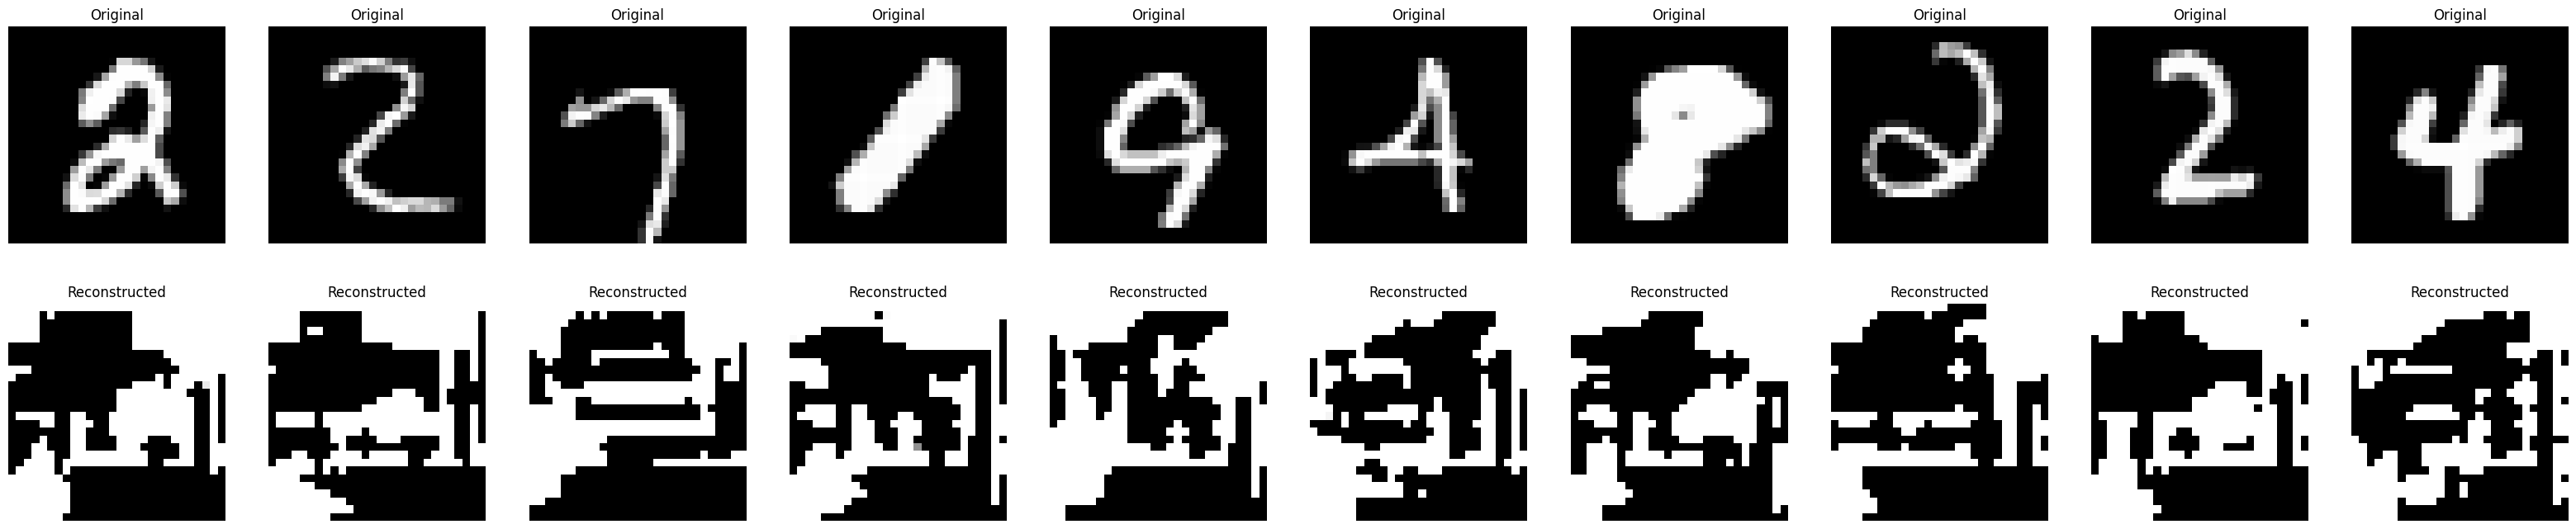

In [ ]:
plot_original_vs_reconstructed(reconstructed=reconstructed_images, original=X_test, columns=10)

313/313 [==============================] - 1s 2ms/step
Classifier accuracy: 0.9839


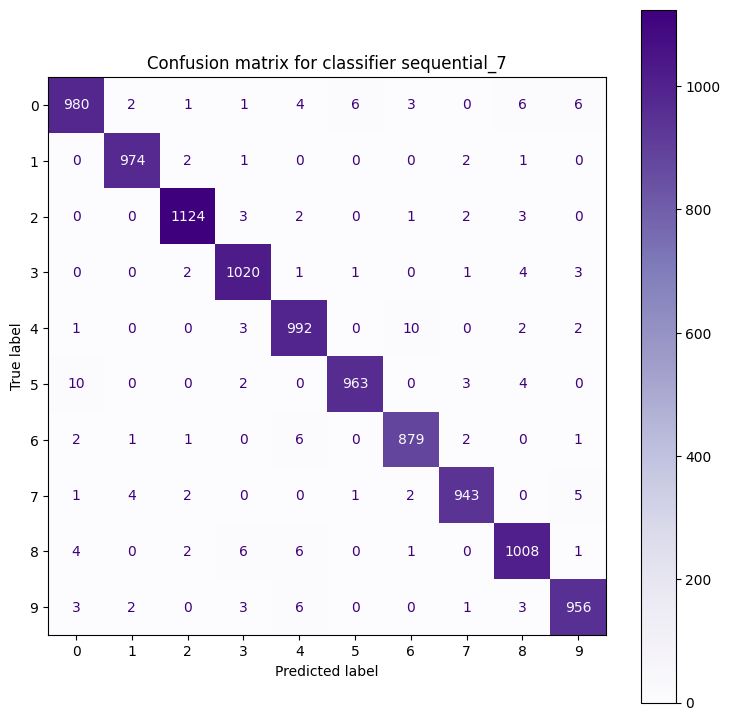

In [ ]:
MNIST_classifier = keras.models.load_model('/gdrive/My Drive/Kaggle/MNIST_classifier.keras')
evaluate_classifier(MNIST_classifier, X_test=reconstructed_images, y_test=((y_test + 1) % 10))

# Variation 7d: Combining 7a and 7c

Before leaving the reconstruct-next problem, we provide a combinatorial idea that merges together the variations 7a and 7c we presented before. The idea is to train an autoencoder using approach 7a, which produces a blurry version of the average 1, 2, 3, etc.. After that, we retrain the model (fine tuning) with the approach 7c, i.e. plugging the classifier at the end, forcing the autoencoder produce output that is correctly classified by the MNIST classifier.

The expected result was to make the 7a results more clear, and more human readable. As we can see there is only a slight improvement (especially in number 2 and 1), but not the expected improvement result.

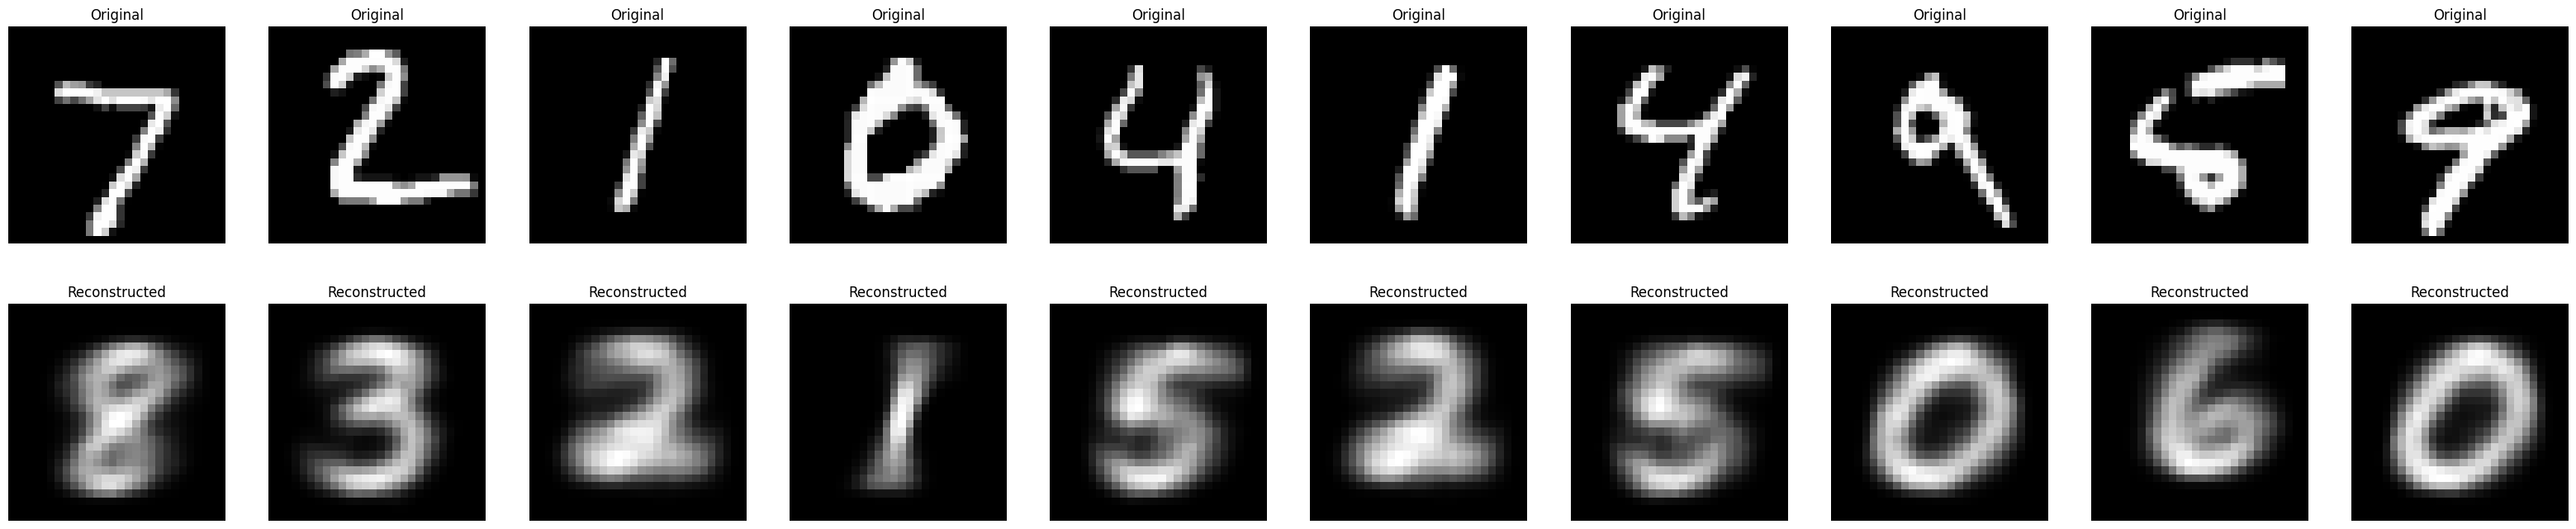

In [ ]:
# ------------------------------ BEFORE FINE TUNING ------------------------------
plot_original_vs_reconstructed(reconstructed=reconstructed_images, original=X_test, columns=10)

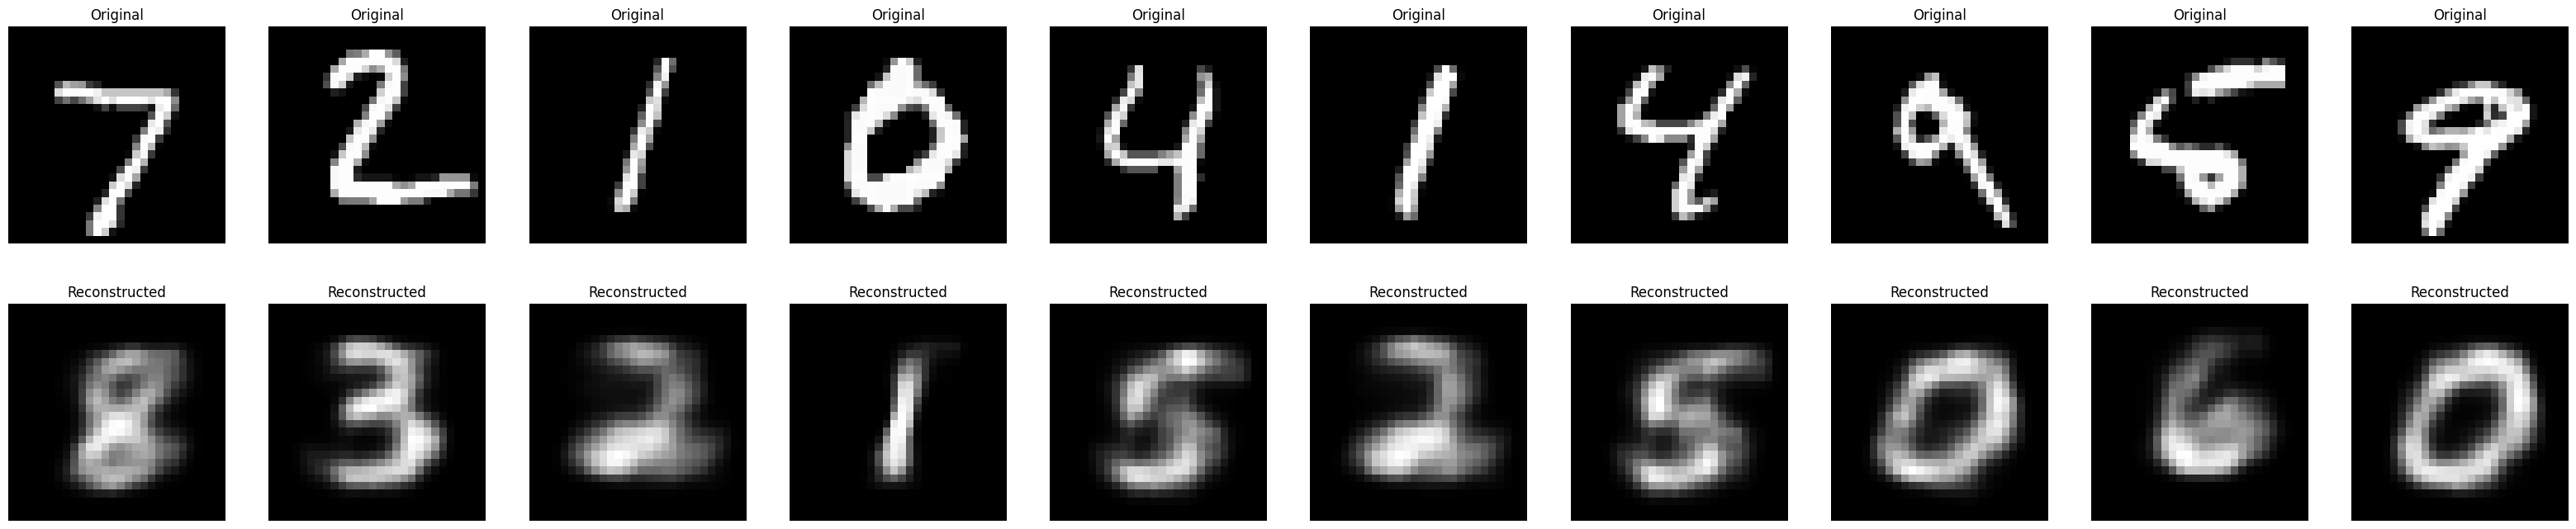

In [ ]:
# ------------------------------ AFTER FINE TUNING ------------------------------
plot_original_vs_reconstructed(reconstructed=reconstructed_images, original=X_test, columns=10)

313/313 [==============================] - 1s 2ms/step
Classifier accuracy: 0.9483


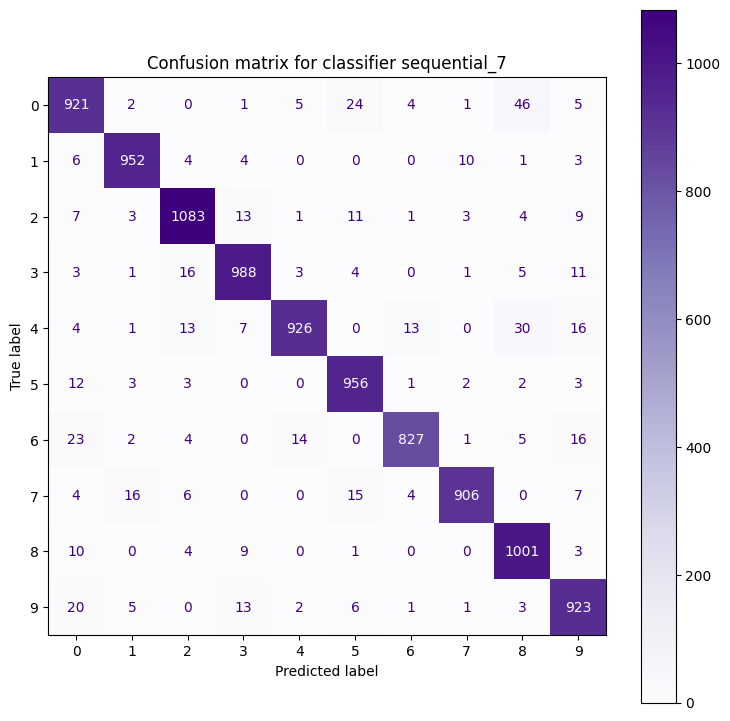

In [ ]:
MNIST_classifier = keras.models.load_model('/gdrive/My Drive/Kaggle/MNIST_classifier.keras')
evaluate_classifier(MNIST_classifier, X_test=reconstructed_images, y_test=((y_test + 1) % 10))

---

#8. Constructing an MNIST adder

In this final section of the assignment, we construct two different versions of an MNIST adder Neural Network. The network takes as input two images depicting two digits (e.g. 5 and 8) and should produce two images that represent the sum of the given numbers (in our example 1 and 3, since $5 + 8 = 13$)

## 8a: Adder version 1 - A classifier

The first approach to solve the problem at hand is to train a NN classifier that can correctly classify an input (two MNIST images) to one of mutually exclusive 19 classes; one for each possible sum (0 - 18). For that purpose, we define and train a classifier, with two encoding parts at the start. For the encoders, we use the weights we found through training at the very beginning of the current notebook.

In [ ]:
import tensorflow as tf
import keras

autoencoder = keras.models.load_model('/gdrive/My Drive/Kaggle/MNIST_autoencoder_classic_3.keras')
left_input  = keras.Input(shape=(28, 28, 1), name="left_input")
x = keras.layers.Conv2D(16, (5, 5), activation='relu', padding='same', strides=(2, 2), weights=autoencoder.layers[1].get_weights(), trainable=False)(left_input)
x = keras.layers.Conv2D( 8, (5, 5), activation='relu', padding='same', strides=(2, 2), weights=autoencoder.layers[2].get_weights(), trainable=False)(x)
x = keras.layers.Conv2D( 8, (5, 5), activation='relu', padding='same', strides=(2, 2), weights=autoencoder.layers[3].get_weights(), trainable=False)(x)
x = keras.layers.Flatten()(x)
left_encoder = keras.models.Model(inputs=left_input, outputs=x, name="left_encoder")

right_input  = keras.Input(shape=(28, 28, 1), name="right_input")
y = keras.layers.Conv2D(16, (5, 5), activation='relu', padding='same', strides=(2, 2), weights=autoencoder.layers[1].get_weights(), trainable=False)(right_input)
y = keras.layers.Conv2D( 8, (5, 5), activation='relu', padding='same', strides=(2, 2), weights=autoencoder.layers[2].get_weights(), trainable=False)(y)
y = keras.layers.Conv2D( 8, (5, 5), activation='relu', padding='same', strides=(2, 2), weights=autoencoder.layers[3].get_weights(), trainable=False)(y)
y = keras.layers.Flatten()(y)
right_encoder = keras.models.Model(inputs=right_input, outputs=y, name="right_encoder")

concatenation_layer = keras.layers.concatenate([left_encoder.output, right_encoder.output])

z = keras.layers.Dense(units=128, activation='relu',    name="Dense_hidden_1")(concatenation_layer)
z = keras.layers.Dense(units= 64, activation='relu',    name="Dense_hidden_2")(z)
z = keras.layers.Dense(units= 32, activation='relu',    name="Dense_hidden_3")(z)
z = keras.layers.Dense(units= 19, activation='softmax', name="Output")(z)

adder_version_1 = keras.models.Model(inputs=[left_encoder.input, right_encoder.input], outputs=z, name="Adder_version_1")
adder_version_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(adder_version_1.summary())


Model: "Adder_version_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 left_input (InputLayer)     [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 right_input (InputLayer)    [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_265 (Conv2D)         (None, 14, 14, 16)           416       ['left_input[0][0]']          
                                                                                                  
 conv2d_268 (Conv2D)         (None, 14, 14, 16)           416       ['right_input[0][0]']         
                                                                                    

The following code cell produces 240'000 train and 60'000 test examples and targets, in order to train the adder.

In [ ]:
from sklearn.utils import shuffle

X_train_permuted_1, y_train_permuted_1 = shuffle(X_train, y_train, random_state=22)
X_train_permuted_2, y_train_permuted_2 = shuffle(X_train, y_train, random_state=26)
X_train_permuted_3, y_train_permuted_3 = shuffle(X_train, y_train, random_state=5)
X_train_permuted_4, y_train_permuted_4 = shuffle(X_train, y_train, random_state=13)
X_train_permuted_5, y_train_permuted_5 = shuffle(X_train, y_train, random_state=7)
X_train_permuted_6, y_train_permuted_6 = shuffle(X_train, y_train, random_state=64)
X_train_permuted_7, y_train_permuted_7 = shuffle(X_train, y_train, random_state=100)
X_train_permuted_8, y_train_permuted_8 = shuffle(X_train, y_train, random_state=222)

X_test_permuted_1, y_test_permuted_1 = shuffle(X_test, y_test, random_state=22)
X_test_permuted_2, y_test_permuted_2 = shuffle(X_test, y_test, random_state=26)
X_test_permuted_3, y_test_permuted_3 = shuffle(X_test, y_test, random_state=5)
X_test_permuted_4, y_test_permuted_4 = shuffle(X_test, y_test, random_state=13)
X_test_permuted_5, y_test_permuted_5 = shuffle(X_test, y_test, random_state=7)
X_test_permuted_6, y_test_permuted_6 = shuffle(X_test, y_test, random_state=64)
X_test_permuted_7, y_test_permuted_7 = shuffle(X_test, y_test, random_state=100)
X_test_permuted_8, y_test_permuted_8 = shuffle(X_test, y_test, random_state=222)


X_train_12 = np.append(X_train_permuted_1, X_train_permuted_2, axis=0)
X_train_34 = np.append(X_train_permuted_3, X_train_permuted_4, axis=0)
X_train_56 = np.append(X_train_permuted_5, X_train_permuted_6, axis=0)
X_train_78 = np.append(X_train_permuted_7, X_train_permuted_8, axis=0)

y_train_12 = np.append(y_train_permuted_1, y_train_permuted_2)
y_train_34 = np.append(y_train_permuted_3, y_train_permuted_4)
y_train_56 = np.append(y_train_permuted_5, y_train_permuted_6)
y_train_78 = np.append(y_train_permuted_7, y_train_permuted_8)

X_test_12 = np.append(X_test_permuted_1, X_test_permuted_2, axis=0)
X_test_34 = np.append(X_test_permuted_3, X_test_permuted_4, axis=0)
X_test_56 = np.append(X_test_permuted_5, X_test_permuted_6, axis=0)
X_test_78 = np.append(X_test_permuted_7, X_test_permuted_8, axis=0)

y_test_12 = np.append(y_test_permuted_1, y_test_permuted_2)
y_test_34 = np.append(y_test_permuted_3, y_test_permuted_4)
y_test_56 = np.append(y_test_permuted_5, y_test_permuted_6)
y_test_78 = np.append(y_test_permuted_7, y_test_permuted_8)


X_train_adder = [np.append(X_train_12, X_train_34, axis=0), np.append(X_train_56, X_train_78, axis=0)]
y_train_adder = np.append(y_train_12, y_train_34) + np.append(y_train_56, y_train_78)

X_test_adder = [np.append(X_test_12, X_test_34, axis=0), np.append(X_test_56, X_test_78, axis=0)]
y_test_adder = np.append(y_test_12, y_test_34) + np.append(y_test_56, y_test_78)

del X_train_12, X_train_34, X_train_56, X_train_78

del X_test_12, X_test_34, X_test_56, X_test_78

del y_train_12, y_train_34, y_train_56, y_train_78

del y_test_12, y_test_34, y_test_56, y_test_78

del X_train_permuted_1, X_train_permuted_2, X_train_permuted_3, X_train_permuted_4, X_train_permuted_5, X_train_permuted_6, X_train_permuted_7, X_train_permuted_8

del X_test_permuted_1, X_test_permuted_2, X_test_permuted_3, X_test_permuted_4, X_test_permuted_5, X_test_permuted_6, X_test_permuted_7, X_test_permuted_8

In [ ]:
print(np.shape(X_train_adder))
print(np.shape(y_train_adder))
print()
print(np.shape(X_test_adder))
print(np.shape(y_test_adder))

(2, 240000, 28, 28)
(240000,)

(2, 40000, 28, 28)
(40000,)


In order to take a closer look at the generated train and test data, we can visualize a random training or test example. The plotted images are the inputs of the adder and the sum result is the target classs.

Random index: 51000


Text(0.5, 0.98, 'Sum = 15')

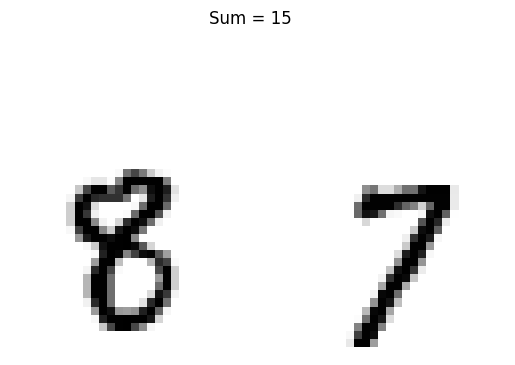

In [ ]:
import matplotlib.pyplot as plt

# random_index = np.random.randint(np.shape(X_test_adder)[1])
# print(f"Random index: {random_index}")

# fig, ax = plt.subplots(1, 2)
# ax[0].imshow(X_test_adder[0][random_index], cmap='gray_r')
# ax[0].axis("off")
# ax[1].imshow(X_test_adder[1][random_index], cmap='gray_r')
# ax[1].axis("off")
# plt.suptitle(f"Sum = {y_test_adder[random_index]}")

random_index = np.random.randint(np.shape(X_train_adder)[1])
print(f"Random index: {random_index}")

fig, ax = plt.subplots(1, 2)
ax[0].imshow(X_train_adder[0][random_index], cmap='gray_r')
ax[0].axis("off")
ax[1].imshow(X_train_adder[1][random_index], cmap='gray_r')
ax[1].axis("off")
plt.suptitle(f"Sum = {y_train_adder[random_index]}")

In [ ]:
# Training the autoencoder
history = adder_version_1.fit(
                               X_train_adder, keras.utils.to_categorical(y_train_adder, num_classes=19),
                               epochs=200,
                               batch_size=128,
                               shuffle=True,
                               validation_data=(X_test_adder, keras.utils.to_categorical(y_test_adder, num_classes=19)),
                               verbose="auto"
                             )

Epoch 1/200
1875/1875 [==============================] - 12s 5ms/step - loss: 1.6810 - accuracy: 0.4438 - val_loss: 1.1071 - val_accuracy: 0.6449
Epoch 2/200
1875/1875 [==============================] - 10s 5ms/step - loss: 0.9402 - accuracy: 0.7009 - val_loss: 0.7896 - val_accuracy: 0.7587
Epoch 3/200
1875/1875 [==============================] - 10s 5ms/step - loss: 0.7343 - accuracy: 0.7699 - val_loss: 0.6575 - val_accuracy: 0.8004
Epoch 4/200
1875/1875 [==============================] - 9s 5ms/step - loss: 0.6334 - accuracy: 0.8027 - val_loss: 0.5901 - val_accuracy: 0.8181
Epoch 5/200
1875/1875 [==============================] - 10s 6ms/step - loss: 0.5660 - accuracy: 0.8238 - val_loss: 0.5423 - val_accuracy: 0.8327
Epoch 6/200
1875/1875 [==============================] - 10s 5ms/step - loss: 0.5223 - accuracy: 0.8376 - val_loss: 0.5009 - val_accuracy: 0.8475
Epoch 7/200
1875/1875 [==============================] - 10s 5ms/step - loss: 0.4841 - accuracy: 0.8499 - val_loss: 0.4632 - 

In [ ]:
adder_version_1.save('/gdrive/My Drive/Kaggle/adder_version_1.keras')

1250/1250 [==============================] - 12s 9ms/step
Classifier accuracy: 0.947025


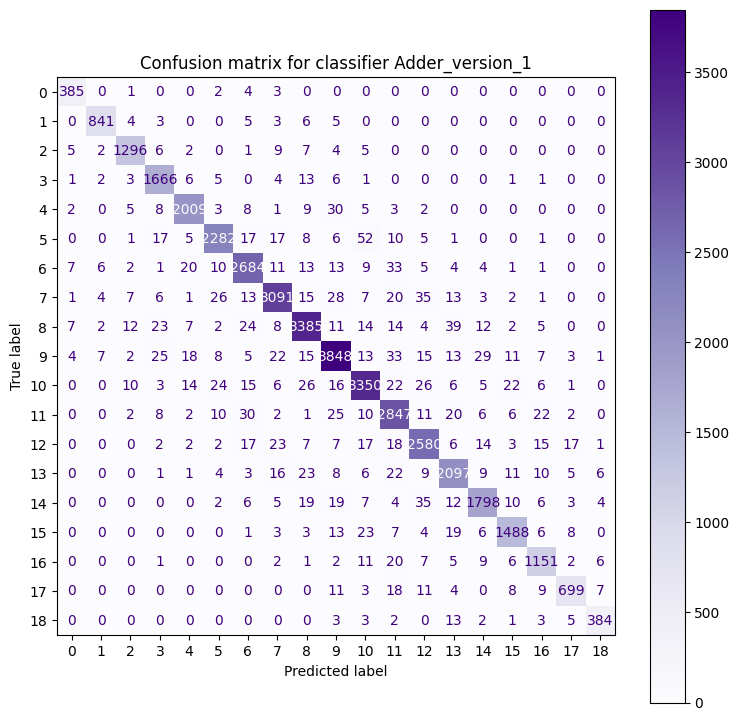

In [ ]:
evaluate_classifier(classifier=adder_version_1, X_test=X_test_adder, y_test=y_test_adder)

The adder-classifier reaches a test accuracy of 0.947025.

## 8b: Adder version 2 - A full autoencoder

Taking our thoughts a step further, we can now create a full autoencoder that takes as input two MNIST images and gives two other that represent the sum of the input digits. For that purpose, we difine an auxiliary custom argmax layer and use it to define the model. We also provide a plot of the model.

In [ ]:
import tensorflow as tf

class argmax_layer(keras.layers.Layer):
  def __init__(self):
    super(argmax_layer, self).__init__()

  def call(self, inputs):
    return tf.math.argmax(inputs, axis=1)

In [ ]:
import tensorflow as tf
import keras

autoencoder = keras.models.load_model('/gdrive/My Drive/Kaggle/MNIST_autoencoder_classic_3.keras')
left_input  = keras.Input(shape=(28, 28, 1), name="left_input")
x = keras.layers.Conv2D(16, (5, 5), activation='relu', padding='same', strides=(2, 2), weights=autoencoder.layers[1].get_weights(), trainable=False)(left_input)
x = keras.layers.Conv2D( 8, (5, 5), activation='relu', padding='same', strides=(2, 2), weights=autoencoder.layers[2].get_weights(), trainable=False)(x)
x = keras.layers.Conv2D( 8, (5, 5), activation='relu', padding='same', strides=(2, 2), weights=autoencoder.layers[3].get_weights(), trainable=False)(x)
x = keras.layers.Flatten()(x)
left_encoder = keras.models.Model(inputs=left_input, outputs=x, name="left_encoder")

right_input  = keras.Input(shape=(28, 28, 1), name="right_input")
y = keras.layers.Conv2D(16, (5, 5), activation='relu', padding='same', strides=(2, 2), weights=autoencoder.layers[1].get_weights(), trainable=False)(right_input)
y = keras.layers.Conv2D( 8, (5, 5), activation='relu', padding='same', strides=(2, 2), weights=autoencoder.layers[2].get_weights(), trainable=False)(y)
y = keras.layers.Conv2D( 8, (5, 5), activation='relu', padding='same', strides=(2, 2), weights=autoencoder.layers[3].get_weights(), trainable=False)(y)
y = keras.layers.Flatten()(y)
right_encoder = keras.models.Model(inputs=right_input, outputs=y, name="right_encoder")

concatenation_layer = keras.layers.concatenate([left_encoder.output, right_encoder.output], name="encoders_concatenation")

adder_version_1 = keras.models.load_model('/gdrive/My Drive/Kaggle/adder_version_1.keras')

z = keras.layers.Dense(units=128, activation='relu',    name="Dense_hidden_1", trainable=False, weights=adder_version_1.layers[11].get_weights())(concatenation_layer)
z = keras.layers.Dense(units= 64, activation='relu',    name="Dense_hidden_2", trainable=False, weights=adder_version_1.layers[12].get_weights())(z)
z = keras.layers.Dense(units= 32, activation='relu',    name="Dense_hidden_3", trainable=False, weights=adder_version_1.layers[13].get_weights())(z)
z = keras.layers.Dense(units= 19, activation='softmax', name="Output", trainable=False, weights=adder_version_1.layers[14].get_weights())(z)
z = argmax_layer()(z)
z = keras.layers.CategoryEncoding(num_tokens=19, output_mode="one_hot")(z)

concatenation_layer2 = keras.layers.concatenate([concatenation_layer, z], name="categorical_merged_concatenation")

z = keras.layers.Dense(128, activation='relu', name="Dense_hidden_4", trainable=True)(concatenation_layer2)
reshape = keras.layers.Reshape(target_shape=(4, 4, 8))(z)

z = keras.layers.Conv2D(8, (5, 5), activation='relu', padding='same', trainable=True)(reshape)
z = keras.layers.UpSampling2D((2, 2))(z)
z = keras.layers.Conv2D(8, (5, 5), activation='relu', padding='same', trainable=True)(z)
z = keras.layers.UpSampling2D((2, 2))(z)
z = keras.layers.Conv2D(16, (3, 3), activation='relu', trainable=True)(z)
z = keras.layers.UpSampling2D((2, 2))(z)
decoded1 = keras.layers.Conv2D(1, (5, 5), activation='sigmoid', padding='same', trainable=True, name="left_output")(z)

z = keras.layers.Conv2D(8, (5, 5), activation='relu', padding='same', trainable=True)(reshape)
z = keras.layers.UpSampling2D((2, 2))(z)
z = keras.layers.Conv2D(8, (5, 5), activation='relu', padding='same', trainable=True)(z)
z = keras.layers.UpSampling2D((2, 2))(z)
z = keras.layers.Conv2D(16, (3, 3), activation='relu', trainable=True)(z)
z = keras.layers.UpSampling2D((2, 2))(z)
decoded2 = keras.layers.Conv2D(1, (5, 5), activation='sigmoid', padding='same', trainable=True, name="right_output")(z)

adder_version_2 = keras.models.Model(inputs=[left_encoder.input, right_encoder.input], outputs=[decoded1, decoded2], name="Adder_version_2")
adder_version_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(adder_version_2.summary())


Model: "Adder_version_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 left_input (InputLayer)     [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 right_input (InputLayer)    [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 16)           416       ['left_input[0][0]']          
                                                                                                  
 conv2d_3 (Conv2D)           (None, 14, 14, 16)           416       ['right_input[0][0]']         
                                                                                    

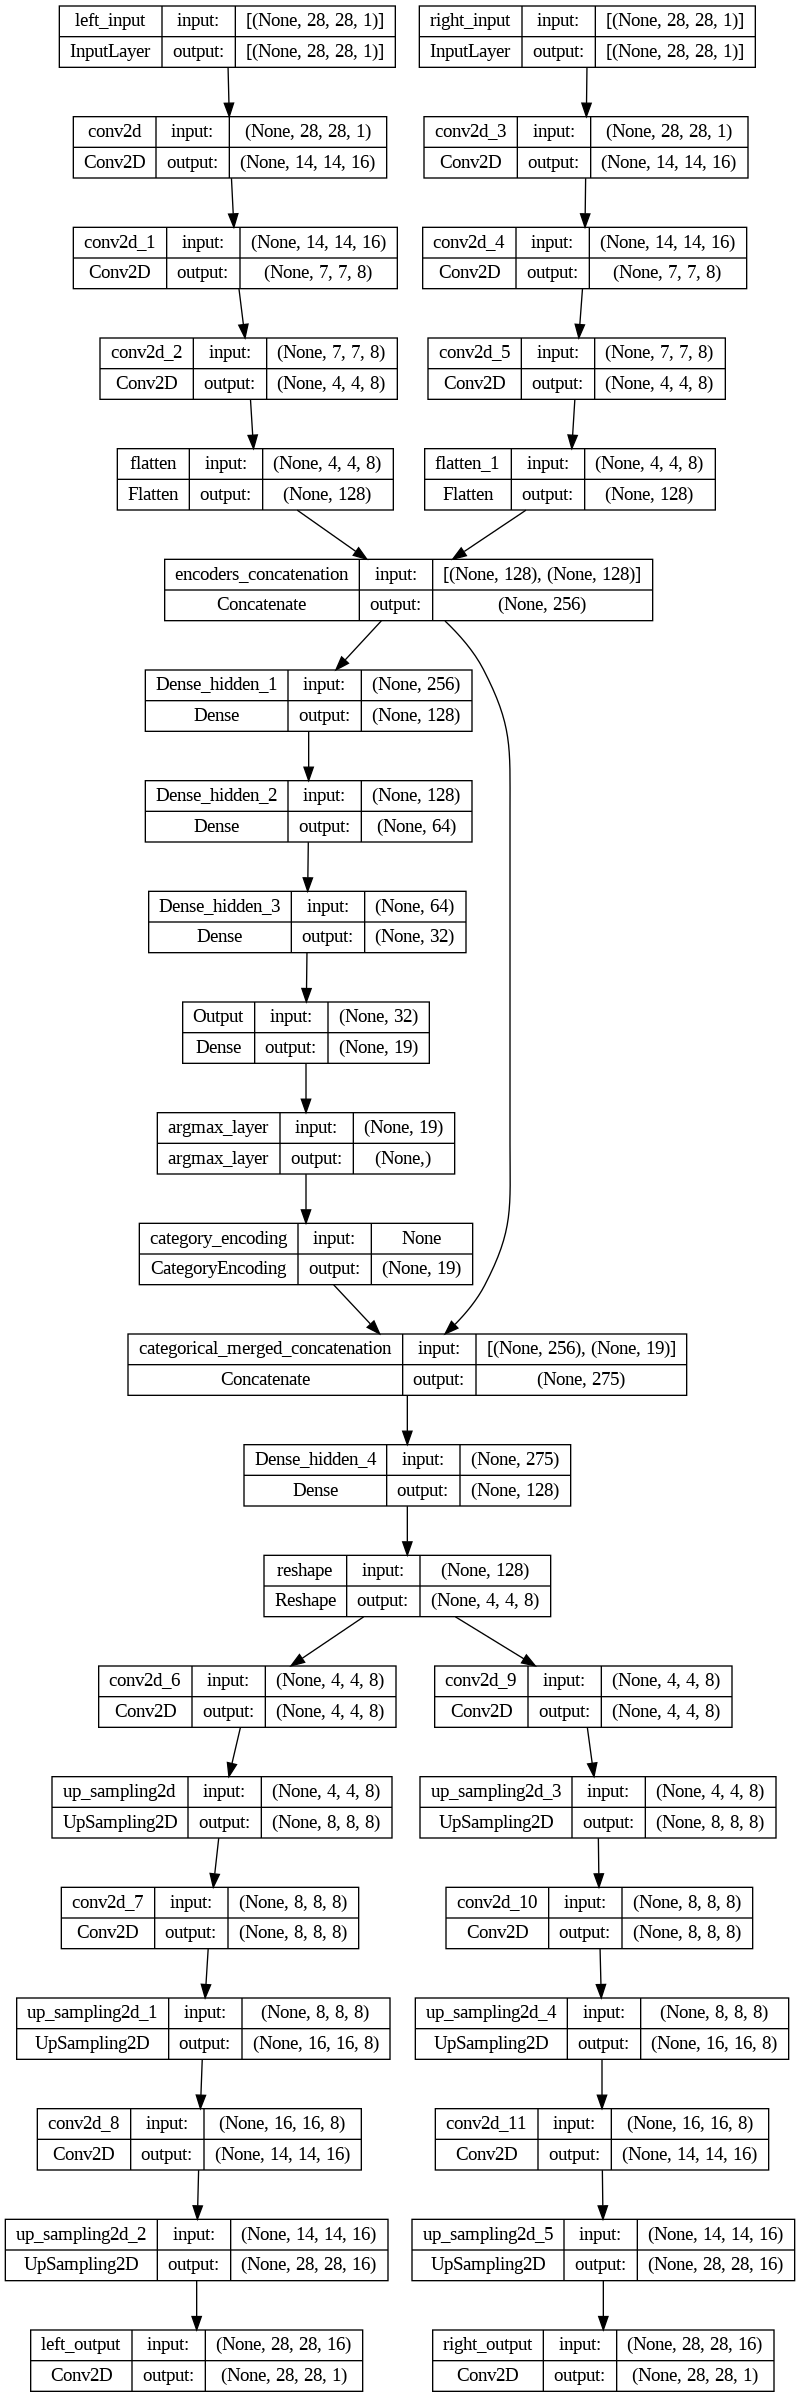

In [ ]:
from keras.utils import plot_model
plot_model(adder_version_2, to_file='model.png', show_shapes=True)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_train_adder_strings = ["{:0>2}".format(number) for number in y_train_adder]
# y_train_adder_images = [
#     np.array([X_train[np.random.choice(digit_indices_train[string[0]])] for string in y_train_adder_strings]),
#     np.array([X_train[np.random.choice(digit_indices_train[string[1]])] for string in y_train_adder_strings])
# ]
y_train_adder_images = [
    np.array([X_train[digit_indices_train[string[0]][0]] for string in y_train_adder_strings]),
    np.array([X_train[digit_indices_train[string[1]][0]] for string in y_train_adder_strings])
]

print(f"Shape of y_train_adder_images: {np.shape(y_train_adder_images)}")


y_test_adder_strings = ["{:0>2}".format(number) for number in y_test_adder]
# y_test_adder_images = [
#     np.array([X_test[np.random.choice(digit_indices_test[string[0]])] for string in y_test_adder_strings]),
#     np.array([X_test[np.random.choice(digit_indices_test[string[1]])] for string in y_test_adder_strings])
# ]
y_test_adder_images = [
    np.array([X_test[digit_indices_test[string[0]][0]] for string in y_test_adder_strings]),
    np.array([X_test[digit_indices_test[string[1]][0]] for string in y_test_adder_strings])
]
print(f"Shape of y_test_adder_images : {np.shape(y_test_adder_images)}")


Shape of y_train_adder_images: (2, 240000, 28, 28)
Shape of y_test_adder_images : (2, 40000, 28, 28)


Random index: 156271


Text(0.5, 0.98, 'Sum = 5')

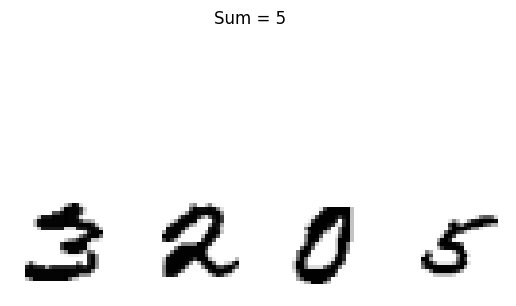

In [ ]:
random_index = np.random.randint(np.shape(X_train_adder)[1])
print(f"Random index: {random_index}")

fig, ax = plt.subplots(1, 4)
ax[0].imshow(X_train_adder[0][random_index], cmap='gray_r')
ax[0].axis("off")
ax[1].imshow(X_train_adder[1][random_index], cmap='gray_r')
ax[1].axis("off")
ax[2].imshow(y_train_adder_images[0][random_index], cmap='gray_r')
ax[2].axis("off")
ax[3].imshow(y_train_adder_images[1][random_index], cmap='gray_r')
ax[3].axis("off")
plt.suptitle(f"Sum = {y_train_adder[random_index]}")

Random index: 3839


Text(0.5, 0.98, 'Sum = 11')

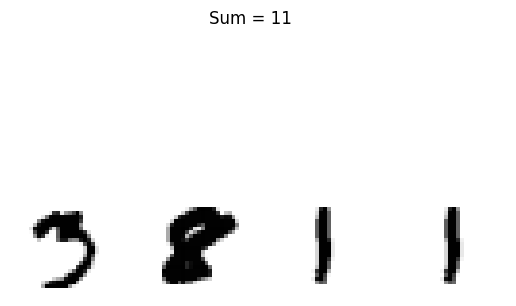

In [ ]:
random_index = np.random.randint(np.shape(X_test_adder)[1])
print(f"Random index: {random_index}")

fig, ax = plt.subplots(1, 4)
ax[0].imshow(X_test_adder[0][random_index], cmap='gray_r')
ax[0].axis("off")
ax[1].imshow(X_test_adder[1][random_index], cmap='gray_r')
ax[1].axis("off")
ax[2].imshow(y_test_adder_images[0][random_index], cmap='gray_r')
ax[2].axis("off")
ax[3].imshow(y_test_adder_images[1][random_index], cmap='gray_r')
ax[3].axis("off")
plt.suptitle(f"Sum = {y_test_adder[random_index]}")

In [ ]:
adder_version_2.load_weights("/gdrive/My Drive/Kaggle/adder_version_2.weights.h5")

In [ ]:
adder_version_2.fit(
                      X_train_adder, y_train_adder_images,
                      epochs=100,
                      batch_size=256,
                      shuffle=True,
                      validation_data=(X_test_adder, y_test_adder_images),
                      verbose="auto"
                    )

# adder_version_2.save('/gdrive/My Drive/Kaggle/adder_version_2.keras')

Epoch 1/100
938/938 [==============================] - 29s 16ms/step - loss: 17.6969 - left_output_loss: 7.8627 - right_output_loss: 9.8342 - left_output_accuracy: 0.7696 - right_output_accuracy: 0.6910 - val_loss: 23.7136 - val_left_output_loss: 11.0508 - val_right_output_loss: 12.6628 - val_left_output_accuracy: 0.8015 - val_right_output_accuracy: 0.6759
Epoch 2/100
938/938 [==============================] - 12s 13ms/step - loss: 17.0167 - left_output_loss: 7.3087 - right_output_loss: 9.7079 - left_output_accuracy: 0.8075 - right_output_accuracy: 0.7156 - val_loss: 23.7471 - val_left_output_loss: 10.9401 - val_right_output_loss: 12.8070 - val_left_output_accuracy: 0.7825 - val_right_output_accuracy: 0.6971
Epoch 3/100
938/938 [==============================] - 12s 12ms/step - loss: 16.7783 - left_output_loss: 7.1875 - right_output_loss: 9.5907 - left_output_accuracy: 0.8079 - right_output_accuracy: 0.7362 - val_loss: 24.5614 - val_left_output_loss: 11.3165 - val_right_output_loss: 13

In [ ]:
adder_version_2.save_weights("/gdrive/My Drive/Kaggle/adder_version_2.weights.h5")

As we can see, the adder produces clear output. Our problem is deemed solved!

Random index: 4971


Text(0.5, 0.98, 'Sum = 11')

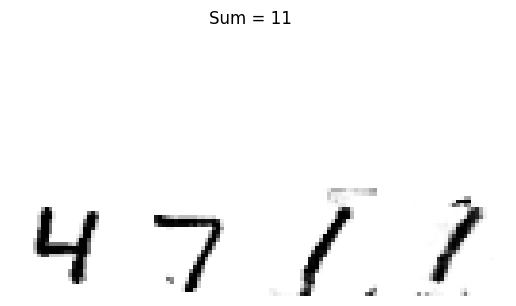

In [ ]:
import keras
import matplotlib.pyplot as plt

# reconstructed_images = adder_version_2.predict(X_test_adder)

random_index = np.random.randint(np.shape(X_test_adder)[1])
print(f"Random index: {random_index}")

fig, ax = plt.subplots(1, 4)
ax[0].imshow(X_test_adder[0][random_index], cmap='gray_r')
ax[0].axis("off")
ax[1].imshow(X_test_adder[1][random_index], cmap='gray_r')
ax[1].axis("off")
ax[2].imshow(reconstructed_images[0][random_index], cmap='gray_r')
ax[2].axis("off")
ax[3].imshow(reconstructed_images[1][random_index], cmap='gray_r')
ax[3].axis("off")
plt.suptitle(f"Sum = {y_test_adder[random_index]}")